<a name="outline"></a>

## Outline

- [Task 1](#task-1): Neural networks
  - [1.1](#q11) Multi-layer perceptron
  - [1.2](#q12) Convolutional neural network (CNN)
- [Task 2](#task-2): Unsupervised learning
  - [2.1](#q21) Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data
  - [2.2](#q22) Clustering of the feature matrix
  - [2.3](#q23) Graph-based analysis 
- [Task 3](#task-3): Mastery component 
  - [3.1](#q31) Non-Negative Matrix Factorization (NMF) for dimensionality reduction 
  - [3.2](#q32) Community detection


<a name="task-1"></a>
# Task 1: Neural networks [^](#outline)



In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from copy import deepcopy

In [2]:
MASTER_SEED = 42

def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    return ((x_train, y_train), (x_test, y_test))

(x_train, y_train), (x_test, y_test) = load_data()

In [3]:
#Progress bar will be useful to gauge how long until algorithm completes
def progress_bar(progress, goal, prepend_str="", steps=20, done_chr=chr(0x25A0), prog_chr=chr(0x2022), empty_chr = chr(0x2022)):
    """
    Creates a progress bar of specified length.

    Args:
        progress           (int): The currect progress of the task begin measured.
        goal               (int): Marker for when progress denotes a completed task.
        prepend_str     (String): String preceding progress bar.                             Defaults to "".
        steps              (int): The number of steps (notches) on the progress bar.         Defaults to 20.
        done_chr        (String): 'Progress bar' character used to display current progress. Defaults to ■.
        prog_chr        (String): Character displayed at the final bar notch.                Defaults to •.
        empty_chr       (String): character used to display remaining progress.              Defaults to •.
    """

    # Convert to float here to allow str based inputs (This way floating-point precision displayed can be controlled)
    norm_prog = float(progress) / float(goal)
    
    bar_prog = int(norm_prog * steps)
    rem_prog = steps - bar_prog
        
    prog_str = (done_chr * bar_prog) + prog_chr + (empty_chr * rem_prog)

    #If progress bar is not complete, then move cursor to start of line so that next call may override printed text
    end = "\r" if bar_prog < steps else ""
    
    print("{}[{}/{}][{}]{:.0%}".format(prepend_str, progress, goal, prog_str[:steps], norm_prog), flush=True, end=end)


In [4]:
print("Image width:", x_train.shape[1], " height:", x_train.shape[2])

Image width: 28  height: 28


<a name="q11"></a>

## 1.1 Multi-layer perceptron [^](#outline)



### 1.1.1 Creating the MLP

The above data `(x_train, y_train)` will be used to train a MLP network, with five HLs (Hidden Layers), 400 neurons per HL and ten output neurons. The data in question is a set of 28x28 pixel pictures with ten potential non-overlapping classifications, hence the input layer will consist of exactly 784 neurons. The activation function, on each of the hidden layers, will be chosen to be LeakyReLU with a slope of $10^{-2}$, which is as defined below:

$$
f(x) = \text{LeakyReLU(x)} = \begin{cases}x & x \geq 0 \\ 10^{-2} \cdot x & x < 0 \end{cases}
$$

$$
f'(x) = \begin{cases}1 & x \geq 0 \\ 10^{-2}  & x < 0 \end{cases}
$$


In [5]:
def LeakyRelUPrime(x, slope = 0.01):
    #result = slope if x < 0 otherwise 1
    return np.where(x < 0, slope, 1)

def LeakyReLU(x, slope=0.01):
    return x * LeakyRelUPrime(x, slope)


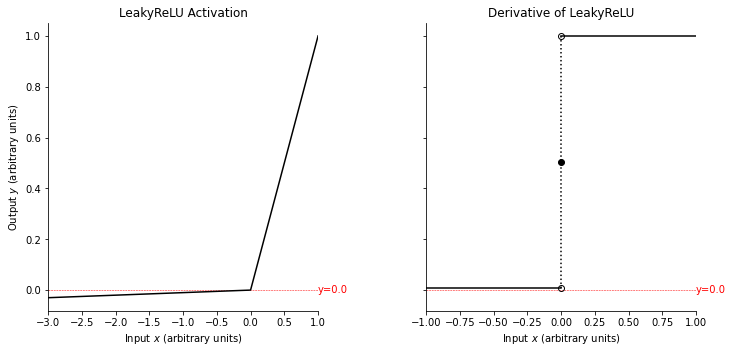

In [6]:
fig = plt.figure()
gs = fig.add_gridspec(ncols=2)
axs = gs.subplots(sharey=True)
fig.subplots_adjust(
    left=0, 
    bottom=0, 
    right=1.5, 
    top=1, 
    wspace=0.4)

for ax in axs:
    #remove right and top sides of rectangling bounding the plots
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #make clear where the line y=0 is
    ax.axhline(y=0, color="red", linestyle="dashed", linewidth=0.5)
    ax.text(1, 0, "y=0.0", color = "red", va = "center")

    ax.set_xlabel("Input $x$ (arbitrary units)")


axs[0].title.set_text("LeakyReLU Activation")
axs[0].set_ylabel("Output $y$ (arbitrary units)")
axs[0].set_xlim(-3, 1)
x0 = np.linspace(*axs[0].get_xlim(), 1001)
axs[0].plot(x0, LeakyReLU(x0), color = "black")


axs[1].title.set_text("Derivative of LeakyReLU")
axs[1].set_xlim(-1, 1)
x1 = np.linspace(*axs[1].get_xlim(), 1000)
sx1 = np.split(x1, 2)
for x in sx1:
    axs[1].plot(x, LeakyRelUPrime(x), color = "black")

#Plot inequality markers
axs[1].plot(0     , (1e-2 + 1)/2, color = 'black', marker = "o")
axs[1].plot(0     , 1e-2        , color = 'black', marker = "o", fillstyle = "none")
axs[1].plot(0     , 1           , color = 'black', marker = "o", fillstyle = "none")
#Plot line connecting discontinuity
axs[1].plot([0, 0], [1e-2, 1]   , color = 'black', linestyle="dotted")

plt.show()

Furthermore, the output will undergo a softmax transformation given by:

$$
\text{softmax($x^{(k)}$)}_j = \frac{exp(x^{(k)}_j)}{\sum_{i=1}^{n_k} exp(x_i^{(k)})}
$$

Where $k$ will denote the output layer, hence $n_k$ the number of nodes (or equivalently outputs). And, $1 \leq j \leq n_k$ the $j^{th}$ output. Furthermore, the metric for error will be given by (categorical) cross-entropy given, in compact form, by:

$$
    \text{CE}(y, \hat{y}) = -y \cdot \log(\hat{y})
$$

With $y = e_i$ for some $i \in \mathbb{N}$, the correct category for the predictors, and $\hat{y} \in \Delta$ $\left(\text{i.e. } \sum_i \hat{y}_i = 1\right)$, the prediction of the category, is given as a probability vector. Of course, since $y_i = 1$ for only one $i$ and zero for all other entries. The cross entropy could be rewritten as:

$$
    \text{CE}(y, \hat{y}) = -\log(\hat{y_i}), \text{ where $i$ is such that $y_i=1$}
$$

In [7]:
def cat_cross_entropy(y_pred, y_actual):
    """
    Returns the cross entropy cost of the input prediction 'y_pred'.

    Args:
        y_pred   (array_like): The prediction (as a probability vector) of the input data.
        y_actual (array_like): The actual category of the data as a basis vector.

    Returns:
        (Integer): The cross entropy error
    """

    #Argmax should always return the index of the entry equal to 1 (Since this is the largest entry)
    category = np.argmax(y_actual, axis = -1)
    #numpy.choose here allows for proper broadcasting of indexing operator    
    return -np.log(np.choose(category, np.transpose(y_pred)))

In [8]:
def softmax(activations):
    """ Returns the softmax of the input 'activations' """

    e_activations = np.exp(activations)
    return e_activations / np.sum(e_activations, axis = -1)[..., np.newaxis]

#Simple testing to ensure correct functionality
test1 = np.array([1, 2])
test1_r = softmax(test1)
assert((test1_r == np.array([np.exp(1), np.exp(2)])/(np.exp(1) + np.exp(2))).all())

#Test correct broadcasting!
test2 = np.array([[1, 2], [3, 5], [8, 20]])
test2_r = softmax(test2)
for test_row, result_row in zip(test2, test2_r):
    assert((result_row == softmax(test_row)).all())


The training will be done by back propagation, first the activation and the pre-activation of all of the layers will be calculated using the following (vectorised) equations:

$$
\mathbf{a}^{(k+1)} = \mathbf{W}^{(k)}\mathbf{h}^{(k)} + \mathbf{b}^{(k)},\hspace{1em} \mathbf{h}^{(k)} = \sigma(\mathbf{a}^{(k)}), \hspace{1em} \mathbf{h}^{(0)} = \mathbf{x}
$$

With the superscript representing the layer upon which the variables have effect. Taking $L_i$ to be the loss function for training sample $i$, successful back propogation requires the initial error to be calculated:

$$
\begin{split}
L_i(\mathbf{a}^{(L+1)}) = CE(\mathbf{y}, \text{softmax($\mathbf{a}^{(L + 1)}$)}) &= -\sum_{i} y_i \log\left(\frac{exp(a^{(L + 1)}_i)}{\sum_{j} exp(a_j^{(L+1)})}\right)\\
&= - \sum_i y_i a^{(L + 1)}_i + \sum_i y_i\log\left(\sum_{j} exp(a_j^{(L+1)})\right) \\
&= - \sum_i y_i a^{(L + 1)}_i + \log\left(\sum_{j} exp(a_j^{(L+1)})\right)\sum_i y_i
\end{split}
$$

Looking at the second term on the right hand side, the sum over the entries of $ y$ evaluates to one, hence the above can be readily simplified to:

$$
L_i(\mathbf{a}^{(L+1)}) = - \sum_i y_i a^{(L + 1)}_i + \log\left(\sum_{j} exp(a_j^{(L+1)})\right)
$$

Taking the derivative with respect to $ a^{L+1}_k$ where $k$ can vary freely across all entries:

$$
\begin{split}
\frac{\partial L_i(\mathbf{a}^{(L+1)})}{\partial a^{(L_1)}_k} &= -y_k + \frac{exp(a^{(L + 1)}_k)}{\sum_{j} exp(a_j^{(L+1)})}\\
&= -y_k + \text{softmax($\mathbf{a}^{(L + 1)}$)})_k
\end{split}
$$

Writting the above in vectorised form gives:

$$
\frac{\partial L_i(\mathbf{a}^{(L+1)})}{\partial \mathbf{a}^{(L+1)}} = \text{softmax($\mathbf{a}^{(L + 1)}$)})-y
$$

The above may be simplified even further by noticing that the models last layer activation function, for this particular case, is the softmax function. Indeed, the prediction of the network may be written as $\hat{\mathbf{y}}=$ softmax $(\mathbf{a}^{(L + 1)})$. Hence, the final derivates can be compactly and succinctly written in the form:

$$
\frac{\partial L_i(\mathbf{a}^{(L+1)})}{\partial a^{(L+1)}} = \hat{\mathbf{y}}-\mathbf{y}
$$

With this, the following recursive relation provides the partial derivatives for the entire network. For simplicity, define: $\frac{\partial L_i(a^{(k)})}{\partial a^{(k)}} = \boldsymbol{\delta}^{(k)}$ and similarly $\frac{\partial L_i(a^{(k)})}{\partial a^{(k)}_i} = \delta^{(k)}_i$:

$$
\boldsymbol{\delta}^{(k)} = diag\left(\sigma'(a^{(k)}_1), \dots, \sigma'(a^{(k)}_{n_k})\right) \left(\mathbf{W}^{(k)}\right)^T \delta^{(k + 1)}
$$
$$
\begin{split}
\frac{\partial L_i}{\partial \mathbf{W}^{(k)}} &= \boldsymbol{\delta}^{(k + 1)} \left(\mathbf{h}^{(k)}\right)^T \\
\frac{\partial L_i}{\partial \mathbf{b}^{(k)}} &= \boldsymbol{\delta}^{(k + 1)}
\end{split}
$$

In [9]:
def CE_softmax_error(y_pred, y_actual):
    """Returns delta (error) of output layer for cross entropy with softmax"""

    return y_pred - y_actual

In [10]:
def create_network(neuron_dist, mean = 0):
    """
    Initialises a neural network with normally distributed weights.

    Args:
        neuron_dist (array): An integer array of the distribution of neurons per layer.
        mean        (float): The mean with which to generate the random weights.        Defaults tos 0.  

    Returns:
        (tuple): A tuple wherein the first and second elements are lists of (np.array) matricies and
        vectors represent the weights and biases of each layer, respectively.
    """

    #Function to shorten long comprehension list
    def normal_f32(prev_layer, curr_layer):
        """Returns normally distributed weights for 'curr_layer'"""

        #Standard deviation
        std = np.sqrt(2/(prev_layer + curr_layer))

        return np.random.normal(mean, std, (prev_layer, curr_layer)).astype(np.float32)
    
    weights = [normal_f32(prev, curr) for prev, curr in zip(neuron_dist, neuron_dist[1:])]
    biases  = [np.zeros(curr, dtype=np.float32) for curr in neuron_dist[1:]]

    return (weights, biases)

In [11]:
def forward_propagate(network, activation_func, input):
    """
    Forward propogate 'network'

    Args:
        network                      (tuple): The neural network as the tuple (weights, biases).
        activation_func (Function(np.array)): The activation function for the hidden layers.
        input                     (np.array): The activations for the input layer of the network

    Returns:
        (array, array): A list of pre activations and post activations at each layer. Note:
        output activation is not applied to final activation! 
    """

    # zeros inserted into pre_acts to ensure resulting array length matches
    # post_acts, hence each index represents pre activation and post
    # activation of each layer.    
    pre_acts  = [np.zeros(input.shape)]
    post_acts = [input]

    for weights, biases in zip(*network):
        a = post_acts[-1] @ weights + biases
        h = activation_func(a)

        pre_acts.append(a)
        post_acts.append(h)

    return pre_acts, post_acts

In [12]:
def network_output(network, activation_func, output_func, input):
    """
    Returns the networks assigned probability that the 'input' data is a given category. 

    Args:
        network                      (tuple): The neural network as the tuple (weights, biases).
        activation_func (Function(np.array)): The activation function for the hidden layers.
        output_func     (Function(np.array)): The activation function for the outout layer.
        input                     (np.array): The activations for the input layer of the network

    Returns:
        (np.array): A probability vector, where each index represents the networks confidence
        that the input data is the given (labelled) category.
    """

    post_acts = forward_propagate(network, activation_func, input)[1]
    return output_func(post_acts[-1])


In [13]:
def outer(lhs, rhs):
    """Broadcastable outer product"""

    return lhs[..., np.newaxis] * rhs[...,np.newaxis,:]

#Testing the outer function produces correct results:
test11 = np.array([1, 2])
test12 = np.array([3, 4])

assert((outer(test11, test12) == np.outer(test11, test12)).all())

#Testing broadcasting works correctly
test21 = np.array([[1, 2], [3, 4]])
test22 = np.array([[5, 6], [7, 8]])
test2_r = outer(test21, test22)

for test21_row, test22_row, test2_r_row in zip(test21, test22, test2_r):
    assert((test2_r_row == np.outer(test21_row, test22_row)).all())

In [14]:

def back_propogate(network, delta, pre_acts, post_acts, activation_prime):
    """
    Returns the derivative of the weights and biases of the network through back propogation.
    Note: A forward propogation needs to be performed first to acquire the pre-activations and
    post-activations.

    Args:
        network                       (tuple): The neural network as the tuple (weights, biases).
        delta                           (int): The last layer delta (error).
        pre_acts                       (list): The pre-activations of the forward propogation.
        post_acts                      (list): The post-activations of the forward propogation.
        activation_prime (Function(np.array)): The total derivative of the activation function 
                                               for the hidden layers.
    """

    del_ws = []
    del_bs = []

    # inital error is the output layer's delta, each element
    errors = [delta]

    for i, weights in reversed(list(enumerate(network[0]))):
        #Acquire the next layer error (i.e. delta^(i + 1))
        error = errors[-1]
        a = pre_acts[i]
        h = post_acts[i]
        
        del_ws.append(outer(h, error))
        del_bs.append(error)

        #Multiplication here is equivalent to matrix product with diagonal matrix
        errors.append(activation_prime(a) * (error @ weights.T))

    # Since backpropogation is performed from the output layer to the input layer (in order),
    # the resultant derivatives are arranged, in their respective array, in reverse order to
    # their layer number. For this reason, they are reversed so that each index matches the
    # corresponding layer the derivative was calculated from
    return del_ws[::-1], del_bs[::-1]


In [15]:
#Input data comes as a 28x28 array, difficult to use with network.
#Instead, flatten such that each row is appended onto the last
#forming a one dimensional array.
flat_x_train = x_train.reshape(x_train.shape[0], -1)
flat_x_test  = x_test.reshape(x_test.shape[0], -1) 

As the optimisation method, stochastic gradient descent (SGD) will be employed with a mini-batch size of 256. The calculation will be performed for a total number of 40 epochs. The algorithm randomly selects (without replacement) a sample of 256 training points from the total training set, namely $D_m \subset (X, y)$. The algorithm then performs a gradient descent using the following recursively relationship:

$$
\theta_{t + 1} = \theta_t - \eta\nabla L(\theta_t; D_m)
$$

Where $\eta > 0$ is a small value governing the rate at which the network evolves and $L$ is, for this scenario, is the mean categorical cross-entropy over the batch:

$$
\theta_{t + 1} = \frac{1}{|D_m|} \sum_{x_i, y_i \in D_m} l(y_i, f_{\theta_t}(x_i)), \hspace{1em} l = CE(y, \hat{y})
$$

With the last unresolved variable, $f_{\theta_t}(x_i)$, the predictions of the neural network at step $t$ in the gradient descent.

In [16]:
#Used as default argument.
def identity_func(*args):
    """Does nothing"""
    pass

In [17]:
def SGD(X, y, network, activation_func, activation_prime, output_func, del_cost, epochs, batch_size, learning_rate=1e-3, callback = identity_func, callback_freq=1):
    """
    Preforms stochastic gradient descent for a number of epochs on a randomly selected batch from
    the whole input training set (without replacement).

    Args:
        X_train                       (np.array): Training data.
        y_train                       (np.array): Expected results for training data.
        network                          (tuple): Network as tuple of (weights, biases).
        activation_func     (Function(np.array)): Activation function for hidden layers.
        activation_prime    (Function(np.array)): Total derivative of 'activation_func'.
        output_func         (Function(np.array)): Activation function for output layer.
        del_cost  (Function(np.array, np.array)): Returns error of output layer.
        epochs                             (int): The number of epochs for which SGD gradient descends.
        batch_size                         (int): The batch size on which gradient is averaged.
        learning_rate          (float, optional): The learning rate. Defaults to 1e-3.
        callback   (Callable(network), optional): Function called after gradient descent. Defaults to identity_func.
        callback_freq            (int, optional): Frequency with which 'callback' is called. Defaults to 1.
    """
    
    data_points = y.shape[0]

    for epoch in range(epochs):
        progress_bar(epoch + 1, epochs, "Epoch: ")

        #Randomly select batch, without replacement
        batch_indicies = np.random.choice(data_points, batch_size, replace=False)

        batch_x = X[batch_indicies]
        batch_y = y[batch_indicies]

        pre_acts, post_acts = forward_propagate(network, activation_func, batch_x)
        output = output_func(post_acts[-1])
        error  = del_cost(output,batch_y)

        del_ws, del_bs = back_propogate(network, error, pre_acts, post_acts, activation_prime)

        #Perform gradient descent on each layer with averaged derivates calculated on batch
        for layer, (del_w, del_b) in enumerate(zip(del_ws, del_bs)):
            network[0][layer] -= learning_rate * np.mean(del_w, axis=0)
            network[1][layer] -= learning_rate * np.mean(del_b, axis=0)

        if epoch % callback_freq == 0:
            callback(network)

    print(" Done!")


The first metric of the neural networks success will be the value of the cost function (which the network attempts to minimise). Alongside this, the accuracy which is given by the number of correct predictions of the network over the total number of predictions. 

In [18]:
def accuracy(y_pred, y_actual):
    """
    Returns the proportion of correct predictions. Converts input probability
    vector prediction into discrete category by choosing the most likely element.

    Args:
        y_pred   (np.array): Probability vector, representing confidence of each category.
        y_actual (np.array): The correct category (1 for correct entry, 0 otherwise).

    Returns:
        float: proportion of correct predicitons.
    """

    #Argmax converts probability distribution into a discrete category in the set
    # {0, ..., 9} which can easily be compared to produce an accuracy
    matching = (np.argmax(y_pred, axis = -1) == np.argmax(y_actual, axis = -1))
    return np.mean(matching)

In [19]:
def q1_general_accuracy_test(in_sample_output, out_sample_output):
    """
    Utility function, generates lambda function which may be passed in
    as the 'test_func' argument to gradient descent methods. Lambda
    produced will fill 'in_sample_out' and 'out_sample_output' array with
    accuracy and costs of the predictions perform by the network, at each
    epoch/training point, on the in sample data and out of sample data.

    Args:
        in_sample_output  (array): Two dimensional array where first row stores
                                   the accuracies of the in sample data, whilst
                                   the second row stores costs.
        out_sample_output (array): Two dimensional array where first row stores
                                   the accuracies of the out of sample data, whilst
                                   the second row stores costs.

    Returns:
        (Function(tuple)): Function performing the task mentioned in summary.
    """

    def result(network):
        pred_in_sample = network_output(network, LeakyReLU, softmax, flat_x_train)
        in_sample_output[0].append(accuracy(pred_in_sample, y_train) * 100)
        in_sample_output[1].append(np.mean(cat_cross_entropy(pred_in_sample, y_train)))

        pred_out_sample = network_output(network, LeakyReLU, softmax, flat_x_test)
        out_sample_output[0].append(accuracy(pred_out_sample, y_test) * 100)
        out_sample_output[1].append(np.mean(cat_cross_entropy(pred_out_sample, y_test)))

    #Return function object to be called later
    return result


In [20]:
np.random.seed(MASTER_SEED)

q11_architecture = [784, 400, 400, 400, 400, 400, 10]
q11_network_base = create_network(q11_architecture)

In [21]:
np.random.seed(MASTER_SEED)

q111_network = deepcopy(q11_network_base)

q111_acc_per_epoch_in_sample = [[], []]
q111_acc_per_epoch_out_sample = [[], []]

SGD(flat_x_train, 
    y_train, 
    q111_network, 
    LeakyReLU, 
    LeakyRelUPrime, 
    softmax, 
    CE_softmax_error,
    epochs=40, 
    batch_size=256, 
    learning_rate=1e-3,
    callback=q1_general_accuracy_test(
        q111_acc_per_epoch_in_sample,
        q111_acc_per_epoch_out_sample
    ))

Epoch: [40/40][■■■■■■■■■■■■■■■■■■■■]100% Done!


In [22]:
def plot_in_out_acc_cost_graphs(in_sample_data, out_sample_data, epochs, learning_rate):
    """
    Plots the accuracies and costs of the in sample and out of sample predictions
    given by a neural network. If epochs is greater than the number of sample points 
    for the graphs (i.e epochs > len(in_sample_data[0])), then a brute force training
    method is assumed to have been used.

    Args:
        in_sample_output  (array): Two dimensional array where first row stores
                                   the accuracies of the in sample data, whilst
                                   the second row stores costs.
        out_sample_output (array): Two dimensional array where first row stores
                                   the accuracies of the out of sample data, whilst
                                   the second row stores costs.
        epochs              (int): The number of epochs the network was trained for
                                   if less than number of sample points. Otherwise,
                                   size of training data.
        learning_rate     (float): The learning rate used to train the network.
    """

    fig, axs = plt.subplots(1, 2)
    fig.subplots_adjust(
        left=0, right=2,
        bottom=0, top=1, 
        wspace=0.4)

    # blue for accuracy, red for loss.
    colours  = ["blue", "red"]
    y_labels = ["Accuracy (%)", "Cost $L$"]
    
    learning_rate_exponent = int(np.log10(learning_rate))
    title_postfix = " comparison of in sample and out of sample data per epoch\n"\
                    f"epochs = {epochs}, learning_rate = $10^{{{learning_rate_exponent}}}$"

    x = np.linspace(1, epochs, len(in_sample_data[0]))
    for i, (in_sample, out_sample) in enumerate(zip(in_sample_data, out_sample_data)):
        ax = axs[i]
        
        ax.set_title(y_labels[i][:-4] + title_postfix)
        ax.set_xlabel("Epochs")
        ax.set_ylabel(y_labels[i])

        ax.plot(x, in_sample,  color=colours[0], label = "In sample")
        ax.plot(x, out_sample, color=colours[1], label = "Out of sample", linestyle="--")
        ax.legend()    
        
    for colour, (accuracy, _) in zip(colours, [in_sample_data, out_sample_data]):
        max_x   = x[np.argmax(accuracy)]
        max_acc = np.max(accuracy)

        rect = Rectangle(
            xy        = (-epochs, -epochs),
            width     = max_x   + epochs,
            height    = max_acc + epochs, 
            facecolor = "none", 
            edgecolor = colour, 
            linestyle = "dotted")
        
        axs[0].add_artist(rect)

In [23]:
def print_max_acc_min_loss(in_sample_data, out_sample_data, prefix=""):
    """
    Outputs to console the maximum accuracy and minimal loss of the in and out of sample data.
    Furthermore, caps output to four decimal places and aligns decimal points.

    Args:
        in_sample_output   (array): Two dimensional array where first row stores
                                    the accuracies of the in sample data, whilst
                                    the second row stores costs.
        out_sample_output  (array): Two dimensional array where first row stores
                                    the accuracies of the out of sample data, whilst
                                    the second row stores costs.
        prefix     (str, optional): String prepended to each output.                  Defaults to "".
    """

    #Aligns decimal points
    print(prefix + "Min in sample loss:         {:>7.4f}".format( min(in_sample_data[1])))
    print(prefix + "Max in sample accuracy:     {:>7.4f}%".format(max(in_sample_data[0])))
    print(prefix + "Min out of sample loss:     {:>7.4f}".format( min(out_sample_data[1])))
    print(prefix + "Max out of sample accuracy: {:>7.4f}%".format(max(out_sample_data[0])))
    

Min in sample loss:          2.2868
Max in sample accuracy:     20.4967%
Min out of sample loss:      2.2873
Max out of sample accuracy: 20.3400%


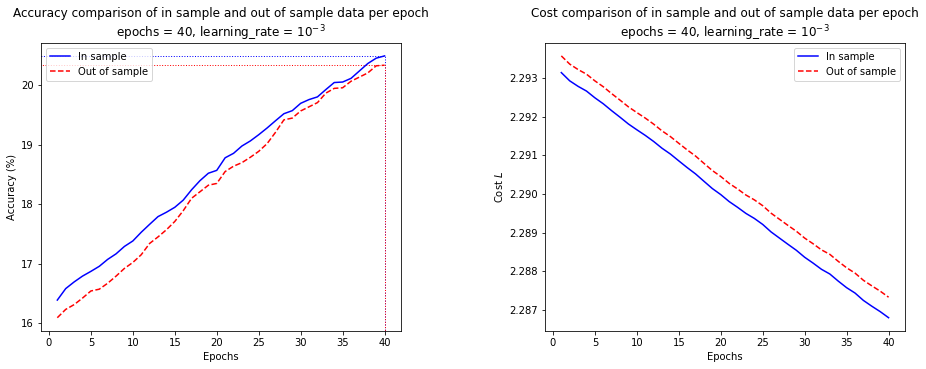

In [24]:
print_max_acc_min_loss(q111_acc_per_epoch_in_sample, q111_acc_per_epoch_out_sample)

plot_in_out_acc_cost_graphs(
    q111_acc_per_epoch_in_sample, 
    q111_acc_per_epoch_out_sample, 
    epochs = 40, 
    learning_rate = 1e-3)

### 1.1.2 Comparing learning rates

In [25]:
np.random.seed(MASTER_SEED)

#rows 0 and 1 contain data for parts (i) and (ii), respectively
q112_acc_per_epoch_in_sample  = [[[], []], [[], []]]
q112_acc_per_epoch_out_sample = [[[], []], [[], []]]

for i, learning_rate in enumerate([1e-5, 1e-1]):
    q112i_network = deepcopy(q11_network_base)

    print("Epochs = 40, learning rate =", learning_rate, end=":\n")
    SGD(flat_x_train, 
        y_train, 
        q112i_network, 
        LeakyReLU, 
        LeakyRelUPrime, 
        softmax, 
        CE_softmax_error,
        epochs=40, 
        batch_size=256, 
        learning_rate=learning_rate,
        callback=q1_general_accuracy_test(
            q112_acc_per_epoch_in_sample[i],
            q112_acc_per_epoch_out_sample[i]
        ))
    

Epochs = 40, learning rate = 1e-05:
Epoch: [40/40][■■■■■■■■■■■■■■■■■■■■]100% Done!
Epochs = 40, learning rate = 0.1:
Epoch: [40/40][■■■■■■■■■■■■■■■■■■■■]100% Done!


Part (i), learning rate = 10^-5:
Min in sample loss:          2.2932
Max in sample accuracy:     16.3267%
Min out of sample loss:      2.2937
Max out of sample accuracy: 16.0200%

Part (ii), learning rate = 10^-1:
Min in sample loss:          0.9653
Max in sample accuracy:     64.5617%
Min out of sample loss:      0.9798
Max out of sample accuracy: 63.7800%


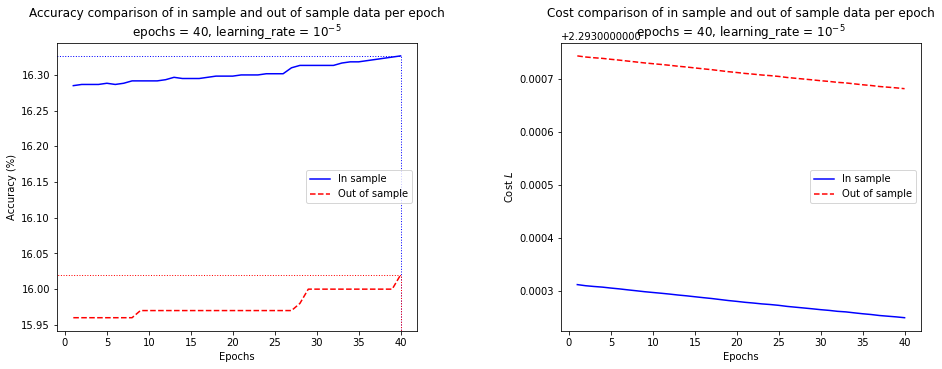

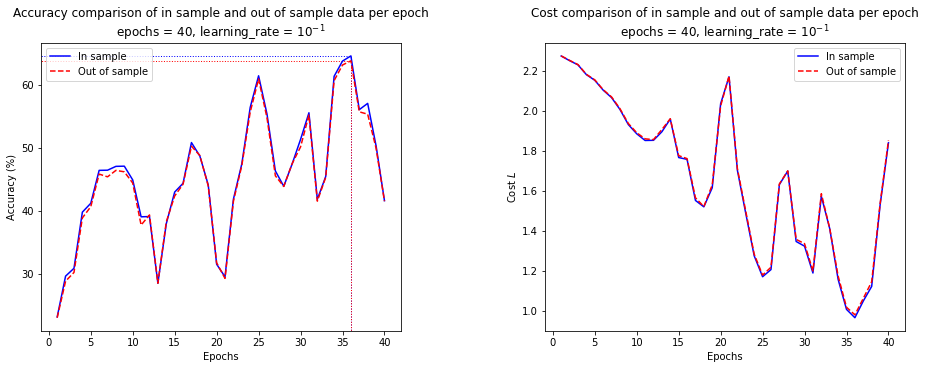

In [26]:
print("Part (i), learning rate = 10^-5:")
print_max_acc_min_loss(q112_acc_per_epoch_in_sample[0], q112_acc_per_epoch_out_sample[0])
print("\nPart (ii), learning rate = 10^-1:")
print_max_acc_min_loss(q112_acc_per_epoch_in_sample[1], q112_acc_per_epoch_out_sample[1])

for i, learning_rate in enumerate([1e-5, 1e-1]):
    plot_in_out_acc_cost_graphs(
        q112_acc_per_epoch_in_sample[i], 
        q112_acc_per_epoch_out_sample[i], 
        epochs = 40, 
        learning_rate = learning_rate)

The first, perhaps unsurprising, observation about all the above networks is that both the accuracy and the loss of the in-sample data (on which the network was trained) trumps the out of sample data's by a visible margin. The loss of each of the networks showed an overall decreasing trend whose gradient was identical for both data sets, yet the offset favoured the in sample data.

For the set of accuracies and losses, where the learning rate was set to $10^{-1}$, it is quite clear to see that the network was able to perform significantly better, when considering the maximum of their metrics, than when $10^{-3}$ was used. Indeed, whilst the network from part 1.1.1 was, in the same time frame, only able to achieve a maximal accuracy and minimum loss of 20.5% and 2.29, whilst the newly trained network achieved 62.6% and 1.12 on epoch 34. This can be effectively attributed to the increased 'speed' of gradient descent given by this learning parameter. The greater the parameter the more bold the network is in moving away from the calculated gradient at its current iteration. However, it is quite clear that this has its downsides, namely a greater probability of it optimising in the wrong direction, overshooting the desired minimum due to the larger steps it takes. This is evident in the jagged nature of the accuracy and loss graph, whose general trend is increasing yet also oscillates wildly in its predictive capabilities. This is in stark contrast to the the slower learning rate, where each improvement is more meek but overall steadier and less likely to decrease. It is without question that a lower learning rate shows more uniform convergence whilst a larger learning rate may never truly converge, constantly missing the minimum of the loss function due its great steps.

The same analysis can be employed on the further lowered learning rate $10^{-5}$. Although the cost of the network was shown to decrease as a whole, it is without question that is severly underperformed when compared to the other two learning rates. In fact, when analysing the accuracy of the out of sample data, the graph shows discrete step-ups in accuracy followed by long plateaus as the epochs increase. This is to be expected, seeing as the calculation of accuracy involves choosing the networks greatest output as the category. For the network to predict differently, either its confidence in the previous prediction must decrease to the point where another classifcation is deemed more likely, the network learns to increase the likelyhood of another classification (asside from the one previously chosen) so that it is the greatest or a combination of the two (most likely). In this sense, there is a certain threshold by which the network must change so that any changes in accuracy may be observed. In this case, the coefficient term of the gradient descent is so small that the changes are only observed after a span of many epochs. The same is not true for the cost, as this is a parameter which is continuously decreased by the network. The cost in this case, is the most stable of all of the previous learning rates, showing the slightest deviation from a straight line. However, even after being trained for fourty epochs and approximately $40 \times 256 = 10240$ data points, roughly one sixth of the training data, the network does not show sufficient progress to extrapolate that its maximal accuracy may reach that of the other networks given a sufficient extension in its training epochs. Indeed, after 240 epochs it becomes inevitable that repeated training points are sampled, and with it increased risk of over-fitting.

### 1.1.3 Comparing number of epochs

In [27]:
np.random.seed(MASTER_SEED)

q113_network = deepcopy(q11_network_base)

q113_acc_per_epoch_in_sample  = [[], []]
q113_acc_per_epoch_out_sample = [[], []]

SGD(flat_x_train, 
    y_train, 
    q113_network, 
    LeakyReLU, 
    LeakyRelUPrime, 
    softmax, 
    CE_softmax_error,
    epochs=80, 
    batch_size=256, 
    learning_rate=1e-3,
    callback=q1_general_accuracy_test(
        q113_acc_per_epoch_in_sample,
        q113_acc_per_epoch_out_sample
    ))

Epoch: [80/80][■■■■■■■■■■■■■■■■■■■■]100% Done!


Min in sample loss:          2.2798
Max in sample accuracy:     23.5283%
Min out of sample loss:      2.2805
Max out of sample accuracy: 23.0800%


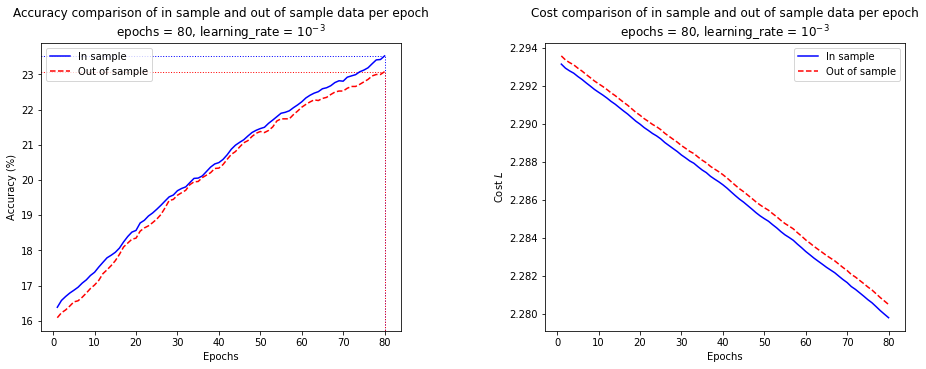

In [28]:
print_max_acc_min_loss(q113_acc_per_epoch_in_sample, q113_acc_per_epoch_out_sample)

plot_in_out_acc_cost_graphs(
    q113_acc_per_epoch_in_sample, 
    q113_acc_per_epoch_out_sample, 
    epochs = 80, 
    learning_rate = 1e-3)

Increasing the number epochs, mostly, produces expected results. The network trained at 40 epochs showed a linear increase in its accuracy and similar decrease in its loss, hence a doubling of its training duration effectly increased and decreased its accuracy and loss once over, respectively. The accuracy shows an ever so slight deviation from linear, slowly flattening in the larger epochs, most evident when considering the out of sample data. This is perhaps evidence that the network is approaching a minima and its gradient is proportionally decreasing in magnitude. However, in stark contrast to this, the cost does not, yet, show any significant 'flattening' in its trajectory, decreasing steadly across the epochs. Especially, when considering the out of sample data. This is a bit unsual seeing as one would expect the cost to be inversely proportional to the accuracy, however this may be evidence that the accuracy is merely going through a momentary reduction in rate of change.

In [29]:
def brute_force_train(X_train, y_train, network, activation_func, activation_prime, output_func, del_cost, learning_rate = 1e-3, callback = identity_func, callback_freq=1):
    """
    Performs gradient descent on and at every training point passed in. Automatically
    updates weights and biases of network passed in. 

    Args:
        X_train                       (np.array): Training data.
        y_train                       (np.array): Expected results for training data.
        network                          (tuple): Network as tuple of (weights, biases).
        activation_func     (Function(np.array)): Activation function for hidden layers.
        activation_prime    (Function(np.array)): Total derivative of 'activation_func'.
        output_func         (Function(np.array)): Activation function for output layer.
        del_cost  (Function(np.array, np.array)): Returns error of output layer.
        learning_rate          (float, optional): The learning rate. Defaults to 1e-3.
        test_func            (network, optional): Function called after gradient descent. Defaults to identity_func.
        test_freq                (int, optional): Frequency with which 'test_func' is called. Defaults to 1.
    """
    
    #Number of training points
    training_points = y_train.shape[0]

    for progress, (X, y) in enumerate(zip(X_train, y_train)):
        progress_bar(progress + 1, training_points, "Training point: ")

        pre_acts, post_acts = forward_propagate(network, activation_func, X)
        output = output_func(post_acts[-1])
        last_err = del_cost(output, y)

        del_ws, del_bs = back_propogate(network, last_err, pre_acts, post_acts, activation_prime)

        for layer, (del_w, del_b) in enumerate(zip(del_ws, del_bs)):
            network[0][layer] -= learning_rate * del_w
            network[1][layer] -= learning_rate * del_b

        if progress % callback_freq == 0:
            callback(network)

    print(" Done!")

In [30]:
brute_force_net = deepcopy(q11_network_base)

bf_acc_per_epoch_in_sample  = [[], []]
bf_acc_per_epoch_out_sample = [[], []]

brute_force_train(flat_x_train, 
    y_train, 
    brute_force_net, 
    LeakyReLU, 
    LeakyRelUPrime, 
    softmax, 
    CE_softmax_error,
    learning_rate=1e-3,
    callback=q1_general_accuracy_test(
        bf_acc_per_epoch_in_sample,
        bf_acc_per_epoch_out_sample
    ), 
    callback_freq=1500)

Training point: [60000/60000][■■■■■■■■■■■■■■■■■■■■]100% Done!


Min in sample loss:          0.3925
Max in sample accuracy:     85.7417%
Min out of sample loss:      0.4299
Max out of sample accuracy: 84.4300%


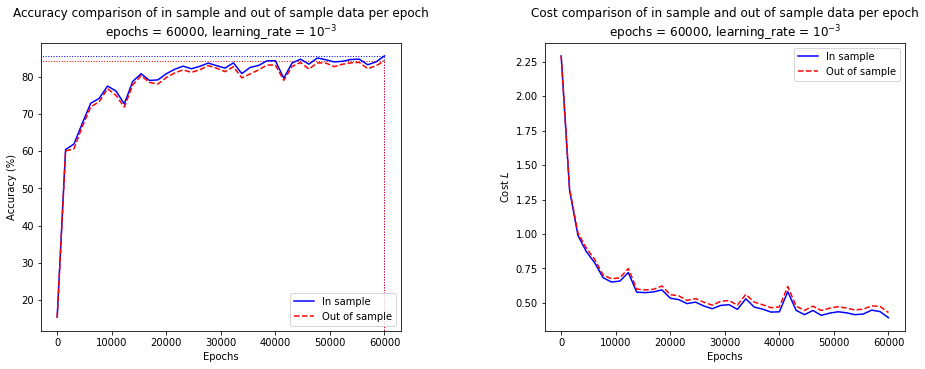

In [31]:
print_max_acc_min_loss(bf_acc_per_epoch_in_sample, bf_acc_per_epoch_out_sample)

#Note, here each training point has its own epoch
plot_in_out_acc_cost_graphs(
    bf_acc_per_epoch_in_sample, 
    bf_acc_per_epoch_out_sample, 
    epochs = flat_x_train.shape[0], 
    learning_rate = 1e-3)

The results above are a quick demonstration of the neural network's potential were it to have been fully trained on the entire dataset (The naïve implementation). It is interesting to use this approach to compare with the SGD algorithm, whereby it produces significantly better results at the cost of similarly greater computational expenditure and, although not exhibited in this example, a stronger risk of overfitting. This computation is, perhaps, indicative of the results expected were one to further increase the number of epochs.  

<a name="q12"></a>
## 1.2 Convolutional neural network (CNN) [^](#outline)

In [32]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, LeakyReLU, Dropout

In [33]:

tf.random.set_seed(MASTER_SEED)

leaky = LeakyReLU(alpha=1e-2)
q121_model = tf.keras.Sequential([
    Conv2D(8,  (3, 3), activation=leaky, input_shape=(28, 28, 1)),
    Conv2D(8,  (3, 3), activation=leaky),
    Conv2D(16, (3, 3), activation=leaky),
    Conv2D(16, (3, 3), activation=leaky),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(64, activation=leaky),
    Dense(10, activation=tf.keras.activations.softmax)
])

q121_model.summary()
q121_model.compile(
    loss="categorical_crossentropy", 
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), 
    metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                        

In [34]:
tf.random.set_seed(MASTER_SEED)

early_stopping  = tf.keras.callbacks.EarlyStopping(patience=15, monitor="val_accuracy")

q121_history = q121_model.fit(
    x=x_train, 
    y=y_train, 
    batch_size=256, 
    epochs=40, 
    verbose=1, 
    validation_data=(x_test, y_test),
    callbacks=[early_stopping],
    use_multiprocessing = True)

Epoch 1/40
235/235 [==============================] - 20s 82ms/step - loss: 2.3036 - accuracy: 0.0851 - val_loss: 2.2967 - val_accuracy: 0.0967
Epoch 2/40
235/235 [==============================] - 19s 81ms/step - loss: 2.2903 - accuracy: 0.1008 - val_loss: 2.2830 - val_accuracy: 0.1058
Epoch 3/40
235/235 [==============================] - 19s 81ms/step - loss: 2.2730 - accuracy: 0.1116 - val_loss: 2.2606 - val_accuracy: 0.1185
Epoch 4/40
235/235 [==============================] - 19s 80ms/step - loss: 2.2395 - accuracy: 0.1286 - val_loss: 2.2097 - val_accuracy: 0.1412
Epoch 5/40
235/235 [==============================] - 19s 80ms/step - loss: 2.1448 - accuracy: 0.2124 - val_loss: 2.0359 - val_accuracy: 0.3225
Epoch 6/40
235/235 [==============================] - 19s 81ms/step - loss: 1.7387 - accuracy: 0.4471 - val_loss: 1.3274 - val_accuracy: 0.5414
Epoch 7/40
235/235 [==============================] - 19s 81ms/step - loss: 1.0631 - accuracy: 0.6152 - val_loss: 0.9244 - val_accuracy:

Min in sample loss:          0.5258
Max in sample accuracy:     80.4867%
Min out of sample loss:      0.5623
Max out of sample accuracy: 78.6700%


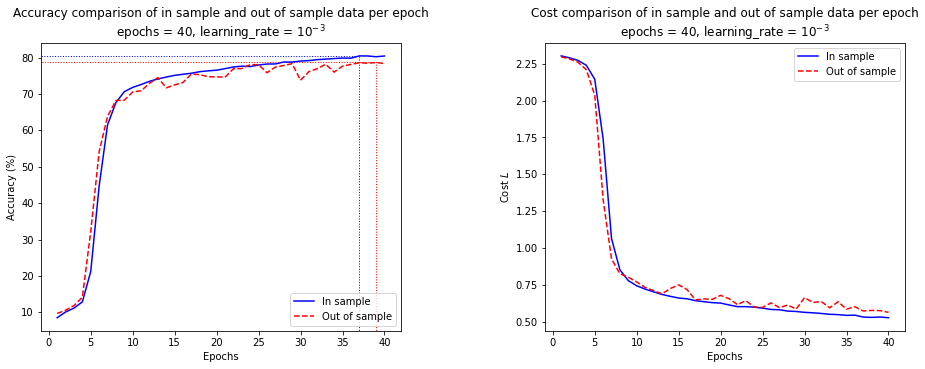

In [35]:
q121_data = q121_history.history
q121_in_sample  = [np.array(q121_data["accuracy"])     * 100, q121_data["loss"]]
q121_out_sample = [np.array(q121_data["val_accuracy"]) * 100, q121_data["val_loss"]]

print_max_acc_min_loss(q121_in_sample, q121_out_sample)

plot_in_out_acc_cost_graphs(
    q121_in_sample, 
    q121_out_sample, 
    epochs=40, 
    learning_rate=1e-3)

For the following set of networks, a new approach will be considered. Namely, dropout. This method was envisioned to help reduce overfitting of a dataset by randomly disconnecting the output of the perceptrons on a particular layer of choice, while maintaining the aggregate activation entering the next. This is done under the assumption that the summed strength of the activations of each perceptron are similar, hence a simple scaling is performed on the output of every non-deactivated neuron:



In [36]:

def get_q122_model(dropout_prob):
    leaky = LeakyReLU(alpha=1e-2)
    model = tf.keras.Sequential([
        Conv2D(8,  (3, 3), activation=leaky, input_shape=(28, 28, 1)),
        Conv2D(8,  (3, 3), activation=leaky),
        Conv2D(16, (3, 3), activation=leaky),
        Conv2D(16, (3, 3), activation=leaky),
        MaxPool2D((2, 2)),
        Flatten(),
        Dense(64, activation=leaky),
        Dropout(dropout_prob),
        Dense(10, activation=tf.keras.activations.softmax)
    ])

    model.compile(
        loss="categorical_crossentropy", 
        optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), 
        metrics=["accuracy"])

    return model

In [37]:
from matplotlib import cm

In [38]:
q122_acc_per_dropout_prob = []
#Values in closed interval [0.1, 0.9]
prob_scan_vals = np.linspace(0.1, 0.9, 9)

#Scan for optimal dropout probability
for probability in prob_scan_vals:
    progress_bar(f"{probability:.1f}" , prob_scan_vals[-1], "Dropout probability: ")

    # Ensures that the same network weights and biases are assigned and SGD
    # is performed on the same mini batches, hence only independant parameter
    # is the dropout probability
    tf.random.set_seed(MASTER_SEED)

    model = get_q122_model(probability)
    history = model.fit(
        x=x_train, 
        y=y_train, 
        batch_size=256, 
        epochs=40, 
        verbose=0, 
        validation_split = 0.2) #2:8, validation:training split

    q122_acc_per_dropout_prob.append(history.history["val_accuracy"])

print(" Done!")



Dropout probability: [0.9/0.9][■■■■■■■■■■■■■■■■■■■■]100% Done!


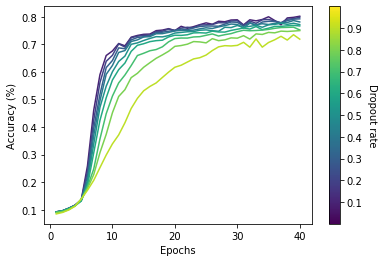

In [39]:
plt.figure()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")

for dropout_rate, dropout_acc_per_epoch in zip(prob_scan_vals, q122_acc_per_dropout_prob):
    plt.plot(
        np.linspace(1, 40, 40), 
        dropout_acc_per_epoch, 
        color=cm.viridis(dropout_rate), 
        label = f"d-rate: {dropout_rate:.1f}")

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cm.viridis), ticks=prob_scan_vals)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Dropout rate", rotation=270)
plt.show()

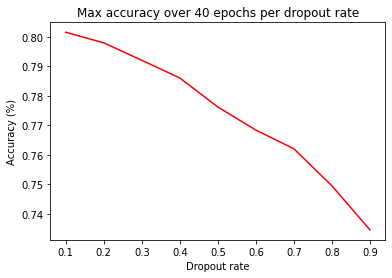

Optimal droupout: 0.1


In [40]:
# The maximum accuracy achieved during training on the validation set will
# be used as the metric for choosing the optimal dropout
q122_max_acc_per_dropout = np.max(q122_acc_per_dropout_prob, axis=1)

plt.figure()
plt.title("Max accuracy over 40 epochs per dropout rate")
plt.xlabel("Dropout rate")
plt.ylabel("Accuracy (%)")
plt.plot(prob_scan_vals, q122_max_acc_per_dropout, color="red")
plt.show()

q122_optimal_dropout = prob_scan_vals[np.argmax(q122_max_acc_per_dropout)]
print("Optimal droupout:", q122_optimal_dropout)

It is quite clear from the above graphs that the combination of the training set and the network architecture seem to favour a lower dropout rate. Indeed, the graph immediately above suggests a non-linear monotonic decrease in the effectiveness of the network as the probability of activation failure increases. Seeing as dropout is a measure designed against overfitting, the natural conclusion is that the network architecture is a good fit for the problem at hand. However, taking a closer look at the at the trained network above, it is quite clear to see the distance between the in sample and out of sample data increasing, for both accuracy and cost. Indeed, it doesn't seem inconceivable that were more epochs to have been trained the validation accuracy may even have to decrease, judging by the plateauing of said graph. In fact, it is shown below that such worries do have merit and that the dropout, although small, is effective in producing better results.

In [41]:
tf.random.set_seed(MASTER_SEED)

q122_optimal_dropout = 0.1
q122_optimal_model = get_q122_model(q122_optimal_dropout)
q122_history = q122_optimal_model.fit(
        x=x_train, 
        y=y_train, 
        batch_size=256, 
        epochs=40, 
        verbose=1, 
        validation_data=(x_test, y_test))

Epoch 1/40
235/235 [==============================] - 20s 83ms/step - loss: 2.3037 - accuracy: 0.0821 - val_loss: 2.2967 - val_accuracy: 0.0968
Epoch 2/40
235/235 [==============================] - 19s 82ms/step - loss: 2.2905 - accuracy: 0.0992 - val_loss: 2.2832 - val_accuracy: 0.1054
Epoch 3/40
235/235 [==============================] - 19s 83ms/step - loss: 2.2738 - accuracy: 0.1147 - val_loss: 2.2614 - val_accuracy: 0.1179
Epoch 4/40
235/235 [==============================] - 19s 83ms/step - loss: 2.2421 - accuracy: 0.1371 - val_loss: 2.2134 - val_accuracy: 0.1391
Epoch 5/40
235/235 [==============================] - 19s 83ms/step - loss: 2.1577 - accuracy: 0.2062 - val_loss: 2.0601 - val_accuracy: 0.3133
Epoch 6/40
235/235 [==============================] - 19s 83ms/step - loss: 1.8333 - accuracy: 0.4053 - val_loss: 1.4648 - val_accuracy: 0.5170
Epoch 7/40
235/235 [==============================] - 19s 82ms/step - loss: 1.2754 - accuracy: 0.5409 - val_loss: 1.0126 - val_accuracy:

Min in sample loss:          0.5497
Max in sample accuracy:      0.7971%
Min out of sample loss:      0.5548
Max out of sample accuracy:  0.7977%


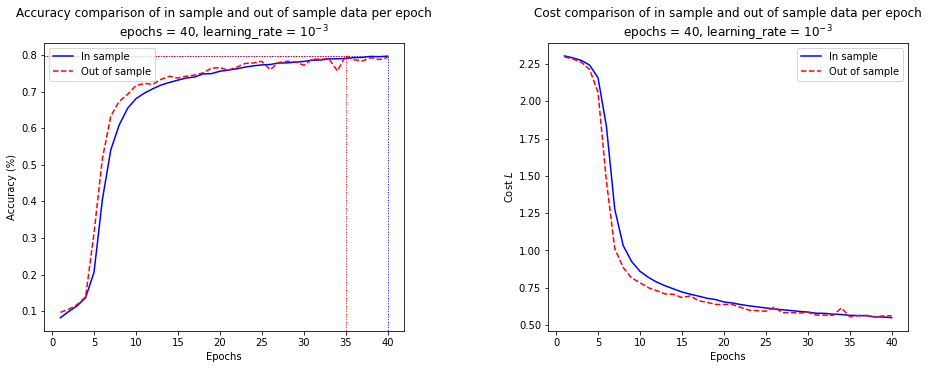

In [42]:
q122_data = q122_history.history
q122_in_sample  = [q122_data["accuracy"], q122_data["loss"]]
q122_out_sample = [q122_data["val_accuracy"], q122_data["val_loss"]]

print_max_acc_min_loss(q122_in_sample, q122_out_sample)

plot_in_out_acc_cost_graphs(
    q122_in_sample, 
    q122_out_sample, 
    epochs=40, 
    learning_rate=1e-3)

Comparing the the scores of these two models (one with dropout, the other without), it is immediately evident that the graphs plotted for the in sample and out of sample data appear much less separated with dropout then without. This is a clear indication of better fitting. Moreover, although the in sample accuracy of the dropout network was marginally smaller than without, 79.71% as opposed to 80.49%, respectively. The actual measure of interest, the out of sample scores, were measurably larger for the dropout network, 79.77% compared to 78.67%; more than 1% better.

The most important fact is that, with less over-fitting, the dropout network can be forseen to continue improving given more epochs. Meanwhile, the no dropout network, as analysed above, is trending either towards a plateau or a drop in predictive capability.

No dropout variance: 14.358191
Dropout variance:    1.4224105


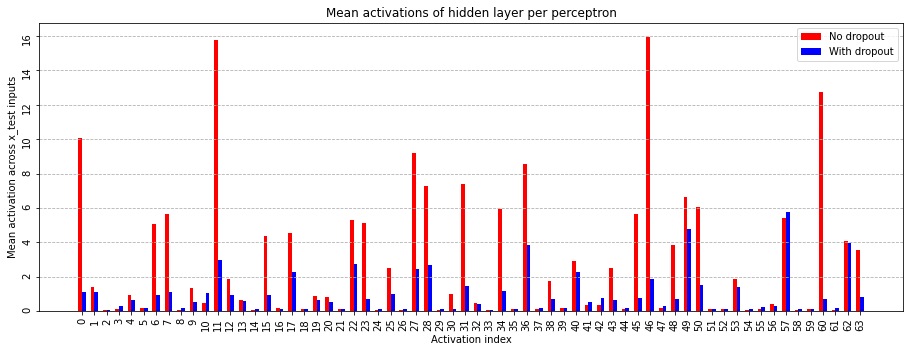

In [43]:
q122_partial_model = tf.keras.Sequential(q122_optimal_model.layers[:-2])
q122_activations = tf.reduce_mean(tf.abs(q122_partial_model(x_test)), axis=0)

q121_partial_model = tf.keras.Sequential(q121_model.layers[:-1])
q121_activations = tf.reduce_mean(tf.abs(q121_partial_model(x_test)), axis=0)

print("No dropout variance:", np.var(q121_activations))
print("Dropout variance:   ", np.var(q122_activations))

fig, ax = plt.subplots()
fig.subplots_adjust(
    left=0, right=2, 
    bottom=0, top=1)

x = np.arange(len(q121_activations))
ax.set_title("Mean activations of hidden layer per perceptron")
ax.set_xlabel("Activation index")
ax.set_ylabel("Mean activation across x_test inputs")
ax.set_xticks(x, x)
ax.tick_params(rotation=90)

bar_width = 0.3
ax.bar(x - bar_width, q121_activations, color="red" , width=bar_width, align="edge", label="No dropout")
ax.bar(x,             q122_activations, color="blue", width=bar_width, align="edge", label="With dropout")

ax.axes.grid(axis="y", linestyle="--")
ax.legend()

Plotting the activations of the fully connected layers for both network (no dropout in red, otherwise blue), it is quite evident to see effects of dropout. The above graph plots the mean magnitude of activation of each perceptron (ranging from 0 to 63) over the out of sample set. The activations of the network without dropout vary more wildly and are generally greater than those with dropout; this is to be expected seeing as dropout regularises the network, reducing the magnitude of activation. Moreover, the variance on these activations is significantly larger for the no dropout network. In this sense, the dropout network seems to place an overall greater important on all of its activations, whilst the no droupout network almost seems to neglect some perceptrons in favour of others. This is perhaps why the dropout network succeeds in reducing overfitting, due to the back propogation process, the network is more likely to favour stronger activations over smaller ones; indeed, looking back at the derivative with respect to the last layer activation of the cost:

$$
\frac{\partial L_i(\mathbf{a}^{(L+1)})}{\partial \mathbf{a}^{(L+1)}} = \text{softmax($\mathbf{a}^{(L + 1)}$)}-y
$$

It shouldn't take too long to be convinced that, per entry, the magnitude of this quantity is going to be larger for larger softmax($\mathbf{a}^{(L + 1)}$). Taking the derivative of this function with respect to its entry activation gives:
$$
\begin{split}
\frac{\partial \text{softmax($\mathbf{a}^{(L + 1)}$)}_i}{\partial \mathbf{a}_i^{(L+1)}} &= \frac{\partial}{\partial \mathbf{a}_i^{(L+1)}}\left(\frac{exp(a^{(L + 1)}_i)}{\sum_{j} exp(a_j^{(L+1)})}\right) \\ &= \frac{exp(a^{(L + 1)}_i)\sum_{j} exp(a_j^{(L+1)}) - exp(2a^{(L + 1)}_i)}{\left(\sum_{j} exp(a_j^{(L+1)})\right)^2}\\
&= \text{softmax($\mathbf{a}^{(L + 1)}$)}_i (1 - \text{softmax($\mathbf{a}^{(L + 1)}$)}_i)
\end{split} 
$$

Similarly for $i \not= k$:
$$
\frac{\partial \text{softmax($\mathbf{a}^{(L + 1)}$)}_i}{\partial \mathbf{a}_k^{(L+1)}} = -\text{softmax($\mathbf{a}^{(L + 1)}$)}_i \text{softmax($\mathbf{a}^{(L + 1)}$)}_k
$$

Which can be rewritten more generally to be:

$$
\frac{\partial \text{softmax($\mathbf{a}^{(L + 1)}$)}_i}{\partial \mathbf{a}_k^{(L+1)}} = \text{softmax($\mathbf{a}^{(L + 1)}$)}_i (\delta_{ik} - \text{softmax($\mathbf{a}^{(L + 1)}$)}_k)
$$

Since the domain of softmax is the interval $(0, 1]$, the derivative is bound to be positive for $i=k$ and negative otherwise. In other words, as given by the normalisation property of the softmax, large single activations decrease the total output of the softmax for other entries yet also increase their own output resulting in larger values for delta at these given 'large' entries. This in turn, may produce a feed-back loop whereby this further increases these already large 'activations', propogating this vicious cycle. For further convincement, looking at the backprogation algorithm, the derivate for both the weights and the bias is proportional to the next layers error, hence eventually also the very last. If these few perceptrons start to exhibit significantly larger activation than others (given the bar plot above for the no-dropout network it seems this is the case), then the network seems to continue to further bolster the activation of these perceptrons, widening the relative difference in magnitude of activations and effectively decreasing the number of perceptrons per layer. To clarify, once the activations of a perceptron are low enough, they contribute little to the prediction and this is what is meant by they are 'effectively removed'.

This line of reasoning is not difficult to fit to the above bar chart, the network has clearly placed greater important on a few perceptrons and has made it so that others have little effect. In this sense, dropout fixes this issue by providing a mechanism whereby dependence on a few activations will cause the performance of the network to tank once these are 'dropped'. It is quite evident from the bars depicting the dropout network, that this bias towards certain perceptrons is greately lessened, hence the network has more computational units at its disposal to perform better.

Network correctly predicts: Yes


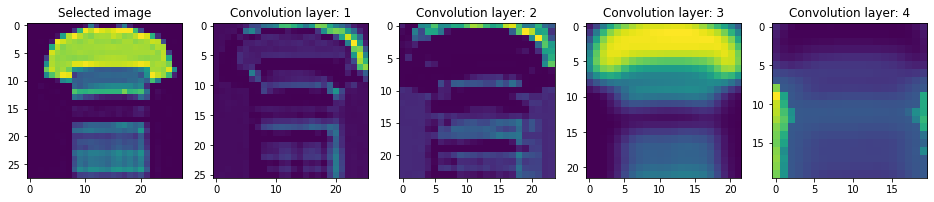

In [44]:
np.random.seed(MASTER_SEED)

random_index = np.random.choice(y_test.shape[0])
random_image = x_test[random_index].reshape(1, 28, 28)

q124_pred = q122_optimal_model.predict(random_image)
print("Network correctly predicts:", "Yes" if accuracy(q124_pred[0], y_test[random_index]) == 1 else "No")

fig, axs = plt.subplots(1, 5, figsize=(5, 5))
fig.subplots_adjust(left=0, right=2.5)

axs[0].set_title("Selected image")
axs[0].imshow(random_image[0])

for i, ax in enumerate(axs[1:]):
    to_conv_layer = tf.keras.Model(
        inputs=q122_optimal_model.inputs, 
        outputs=q122_optimal_model.layers[i].output)

    filters = to_conv_layer(random_image)
    ax.set_title(f"Convolution layer: {i+1}")
    ax.imshow(filters[0,:,:,0])


Displaying the outputs of a single feature, through its various convolutional layers, tells a great deal about how the network seems to be reaching it's various classifications. For this particular sample and feature (chosen for no particular reason), the first two convolutions display great activation around the top of the shirt, perhaps acting as a sort of edge detector. Moreover, it is quite interesting to note that it also seems to show relatively greater activation on the stripes of the shirt. This should, in theory, have little to no impact on the classification but perhaps it's more common in this data set for certain classifications of clothing to have stripes, such as shirts, hence the network has picked up on this. One may argue that this is simply noise carried forward from the input image, however, notice that the area of greatest value of the image, the torso, has little to no activation in the first convolution, in contradiction to this point. 

The third convolutional layer, seems to place greater importance on the sleeves and upper breast area. This, to a human observer, seems like a very distinct feature of a shirt, namely its short sleeves and mostly flat chest area, which the network seems to be picking up on. The last convolution instead focuses on the empty areas of the image, indeed these provide just as much information about the shape of the object as checking for the object itself.

<a name="task-2"></a>

# Task 2: Unsupervised learning [^](#outline)

<a name="q21"></a>

## 2.1 Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data [^](#outline)

In [45]:
from scipy.sparse import linalg

Briefly, PCA is a dimensionality reducing algorithm, whose main assumption is that a set $\{x^{(i)} \in \mathbb{R}^p\}_{i=1}^N$ of data points may be decomposed into $x^{(i)} = \tilde{x}^{(i)} + \epsilon$, whereby $\dim(\tilde{x}^{(i)}) = m < p$ and $\epsilon$, sometimes termed 'noise', is independant of $x^{(i)}$. With this assumption, it is evident that there are only $m$ useful descriptors of the original data set $\{x^{(i)}\}_{i=1}^N$, whilst the remaining $p - m$ descriptors are either noise or somehow dependant on these unknown $m$ properties. The PCA algorithm strives to provide an optimal set of such 'dimensionaly reduced' descriptors given a threshold value dictating whether $\epsilon$ is considered noise.

Indeed, consider a set of predictors $\{\phi_1, \dots, \phi_p \}$, an orthonormal basis over $\mathbb{R}^p$. Hence, $x^{(i)} = \sum_{j=1}^p a^{(i)}_j \phi_j$. However, given the assumption that there is noise in this data, there exists a subspace (with dimension $p - m$) which is of the form $\{\phi_{m+1},\dots,\phi_{p}\}$ (Here, the orthonormal basis has been relabelled to ensure the last basis vectors are as such), which represents such noise. Given the assumption of independance, the data may be approximated as: $x^{(i)} \approx x^{(i)}_m = \sum_{j=1}^m a^{(i)}_j \phi_j + \sum_{j=m+1}^p b_{j-m} \phi_j$, noting that $b_j$ is independant of the choice of $i$. From this, the goal is to find $\{\phi_i\}_{i=1}^m$ and $\mathbf{b} = (b_i, \dots, b_{p-m})^T$ that minimises the mean squared error. Where each individual error is given by $\Delta x^{(i)} = x^{(i)} - x^{(i)}_m = \sum_{j=m+1}^p (a^{(i)}_{j} - b_{j-m}) \phi_j$. Hence, the mean squared error is:

$$
\begin{split}
MSE = \frac{1}{N} \sum_{i=1}^N \| \Delta x^{(i)}\|^2 &= \frac{1}{N} \sum_{i=1}^N \left(\Delta x^{(i)}\right) ^ T \Delta x^{(i)}\\
&= \frac{1}{N} \sum_{i=1}^N \left[ \left(\sum_{j=m+1}^p (a^{(i)}_{j} - b_{j-m}) \phi_j^T \right) \left(\sum_{j=m+1}^p (a^{(i)}_{j} - b_{j-m}) \phi_j \right)  \right]\\
(\phi_i \text{ are orthormal})&=\frac{1}{N} \sum_{i=1}^N  \sum_{j=m+1}^p (a^{(i)}_{j} - b_{j-m})^2  \\
\end{split}
$$

First, taking the derivative with respect to $\mathbf{b}$:

$$
\begin{split}
\frac{\partial MSE}{\partial b_{k}} &=  \frac{-2}{N} \sum_{i=1}^N (a^{(i)}_{k + m} - b_{k}) \\
&= 2(b_{k} -  \langle a_{k + m} \rangle)
\end{split}
$$

Hence, $MSE\mid_{b^*}$ is minimised by $b^*_k = \langle a_{k + m}\rangle$. Substituting this optimal values into the $MSE$ and rearranging it follows that this $MSE$ can be written as:

$$
MSE = \sum_{j=m+1}^p \phi_j^{T} C_\mathbf{x} \phi_j
$$

Where $C_\mathbf{x}$ is the covariance matrix given by $(C_{\mathbf{x}})_{ij} = \langle (x^{(i)} - \langle x^{(i)} \rangle) (x^{(j)}- \langle x^{(j)} \rangle )\rangle$, which is clearly symmetric. this matrix also so happens to be semi-positive definite. To see this, consider the the quantity:

$$
\begin{split}
0 \leq \left\| (I - \frac{1}{N} \mathbf{1}\mathbf{1}^T)\mathbf{X}\mathbf{y}\right\| &= \left[\left(I - \frac{1}{N} \mathbf{1}\mathbf{1}^T\right)\mathbf{X}\mathbf{y}\right]^T\left[\left(I - \frac{1}{N} \mathbf{1}\mathbf{1}^T\right)\mathbf{X}\mathbf{y} \right]\\
&= \mathbf{y}^T \mathbf{X}^T \left(I - \frac{1}{N} \mathbf{1}\mathbf{1}^T\right)^2 X\mathbf{y} = \mathbf{y}^T N\mathbf{C}_{\mathbf{x}} \mathbf{y}
\end{split} 
$$

The importance of which will be reaveled later. Calculating the minima of the new MSE under the condition that $\{\phi^*_i\}_{i=1}^p$ must be orthonormal (by means of Lagrange multipliers) gives that the basis which minimises the MSE satisfies $C_{\mathbf{x}}\phi^*_i = \lambda_i\phi^*_i$. These are the eigenvectors of the covariance matrix, also called the principle components, and they allows for the minimum $MSE$ to be calculated with respect to the free variable $m$:

$$
MSE = \sum_{j=m+1}^p \phi_j^{T} C_\mathbf{x} \phi_j = \sum_{j=m+1}^p \phi_j^{T} \lambda_j \phi_j = \sum_{j=m+1}^p \lambda_j
$$

From here, it is clear that in order to minimise the error, the smallest possible eigenvalues need to be chosen as the discarded set. And then $m$ chosen such that a good balance is struck between the number of dimensions and the value of the $MSE$. As a sanity check, the semi-postive definiteness of $C_{\mathbf x}$ ensures that all of its eigenvalues are non-negative, hence ensuring that a negative $MSE$ is impossible, as it should be.


In [46]:
def standardise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

q211_X_std = standardise(flat_x_train[:1000])

In [47]:
def pca_function(X,k):
    """
    Performs PCA dimensionality reduction algorithm on input data set.

    Args:
        X (np.array): A numpy array of shape (N, D) where the rows represent the samples
                      and the columns its features
        k  (integer): The number of principle components to return

    Returns:
        The samples in terms of the greatest k principle components, the
        greatest k principle components and their eigenvalues
    """

    C_x =  X.T@ X / (X.shape[0] - 1)

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C_x, k, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues  = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:,sorted_index]

    return X @ eigenvectors, eigenvectors, eigenvalues

Choice of m: 8


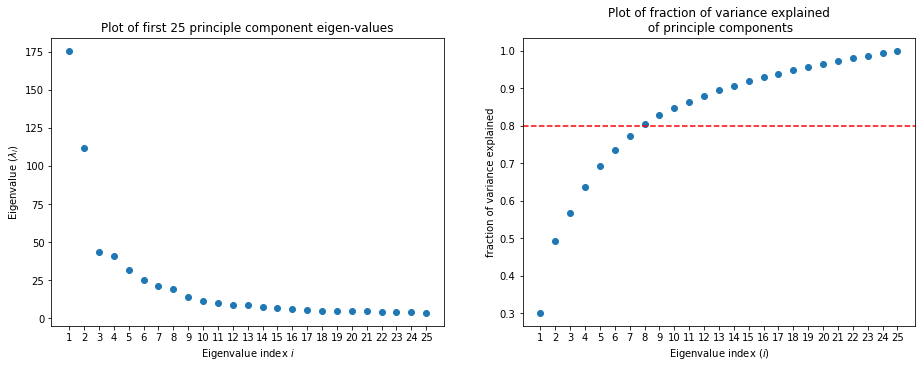

In [48]:
np.random.seed(MASTER_SEED)

q211_x_pca, q211_eig_vecs, q211_eig_vals = pca_function(q211_X_std, 25)

#Get the explained variance per the number of principle components
#which is just the cumulative sum
q211_cum_var = np.cumsum(q211_eig_vals)/np.sum(q211_eig_vals)

q211_eig_val_index = np.arange(q211_eig_vals.shape[0]) + 1

fig, axs = plt.subplots(1, 2)
fig.subplots_adjust(
    left=0, right=2,
    bottom=0, top=1)

axs[0].set_title("Plot of first 25 principle component eigen-values")
axs[0].set_xlabel("Eigenvalue index $i$")
axs[0].set_ylabel("Eigenvalue ($\lambda_i$)")
axs[0].set_xticks(q211_eig_val_index)

axs[0].scatter(q211_eig_val_index, q211_eig_vals)

axs[1].set_title("Plot of fraction of variance explained\n of principle components")
axs[1].set_xlabel("Eigenvalue index ($i$)")
axs[1].set_ylabel("fraction of variance explained")
axs[1].set_xticks(q211_eig_val_index)

axs[1].scatter(q211_eig_val_index, q211_cum_var)
axs[1].axhline(y=0.8, color="red", linestyle="--")

threshold = 0.8
#Select the first value which is greater than 0.8
choice_m = q211_eig_val_index[np.nonzero(q211_cum_var > threshold)][0]
print("Choice of m:", choice_m)

When choosing the number of dimensions $(k)$ to reduce the data to, using the PCA algorithm, it is customary to choose $m$ such that the explained variance is above 80%. In this particular example, it is clear that this threshold is barely surpassed by $m=8$ (The graph on the right). The graph on the left provides some assurance that this is indeed a good. It is clear to see that past the chosen $m$ the eigenvalues significantly plateau, resulting in little to no effect on the $MSE$ calculated above and hence explanative power over the data set.

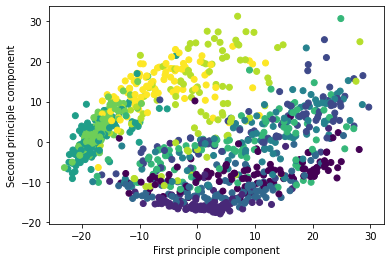

In [49]:
q213_y_cats = np.argmax(y_train[:len(q211_X_std)], axis=-1)

plt.figure()
plt.xlabel("First principle component")
plt.ylabel("Second principle component")
plt.scatter(q211_x_pca[:, 0], q211_x_pca[:, 1], c=q213_y_cats)
plt.show()

Choosing the top two most significant principle components, so that they may be plotted, then giving each point a different colour depending on their category, the data points seem to be loosely clustered. Indeed, especially for the points marked in yellow and purple, one can see that they tend to pack themselves into a specific region. This is greatly indicative of clustering on the data set as whole, seeing as the top two principle components are responsible for just over 50% of the fraction of variance explained, hence patterns in this reduction are likely to appear when considering a larger pool of principle components.

To Try to group these clusters, the k-means algorithm will be utilised to minimise the normalised within distance $W$, for a given number of desired clusters $k$:

$$
W(C) = \frac{1}{2} \sum_{l=1}^k \frac{1}{|c_l|} \sum_{i, j \in c_l} ||\mathbf{x}^{(i)} - \mathbf{x}^{(j)}||^2
$$

This may be rewritten, in marix form, given the $(N \times k)$ assigment matrix $H$, where each row represents one of the data samples, and the columns represent what cluster this particular sample point has been assigned to. In other words $H_{ij} = 1$ if $\mathbf{x}^{(i)}$ belongs to the cluster $j$ and 0 otherwise. Since cluster assignments are unique, each row will only have one non-zero entry. Moreover, define the distances matrix $D_{ij}$ = $||\mathbf{x}^{(i)} - \mathbf{x}^{(j)}||^2$, hence $W(C)$ may be written as:

$$
W(C) = \frac{1}{2}\text{Tr}\left[(H^T H)^{-1}(H^T D H)\right]
$$

Finally, the K-means algorithm may be summarised as follows:

1. Randomly assign a cluster (denoted by a value in $\{0, \dots, k-1\}$) to each $\mathbf{x}^{(i)}$ in the data set.
2. Compute the centroid of each cluster, which is simply the mean over all points in each cluster.
3. Reassign each $\mathbf{x}^{(i)}$ to the cluster whose centroid is closest to them (using the euclidian metric)
4. Repeat steps 2-4 until no new assignments are made, or you run out of patience.



In [50]:
def centroids_per_label(X, k, labels):
    """Computes the centroid of each given cluster

    Args:
        X      (np.array): A numpy array of predictors
        k           (int): The total number of clusters.
        labels (np.array): An integer array, representing the cluster assignment
                           of each sample in X.

    Returns:
        np.array: The centroids of each cluster
    """

    centroids = np.zeros((k, X.shape[1]))

    for label in range(k):
        choose = labels == label
        #Avoid division by zero error
        if choose.any():
            centroids[label] = np.mean(X[choose], axis=0)

    return centroids


def k_mean(X, k, patience=15):
    """_summary_

    Args:
        X             (np.array): A numpy array of predictors
        k                  (int): The number of clusters one wishes to produce.
        patience (int, optional): The maximum number of iterations until the algorithm stops. Defaults to 15.

    Returns:
        (np.array, np.array): The centroids of each cluster and the cluster assignments.
    """

    N, D = X.shape

    labels = np.random.randint(0, k, N)
    centroids = centroids_per_label(X, k, labels)

    for iteration in range(patience):
        distances = [np.linalg.norm(X - centroid, axis=-1) for centroid in centroids]

        #New labels point to shortest cluster
        new_labels = np.argmin(distances, axis=0)
        #If no new labels have been changed, algorithm is complete
        if((new_labels == labels).all()):
            break
        else:
            labels = new_labels
            centroids = centroids_per_label(X, k, labels)

    
    return centroids, labels

In [51]:
def pairwise_distances(points):
    '''
    Args:
        points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
    Returns:
        A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
    '''
    N, D = points.shape
    distance = np.empty((N, N))
    
    # distance matrix will be symmetric, so avoid redundant computations.
    for i in range(N):
        distance[i, i] = 0
        for j in range(i + 1, N):
            d = np.sqrt(np.power(points[i, :] - points[j, :], 2).sum())
            distance[i, j] = d
            distance[j, i] = d
            
    return distance

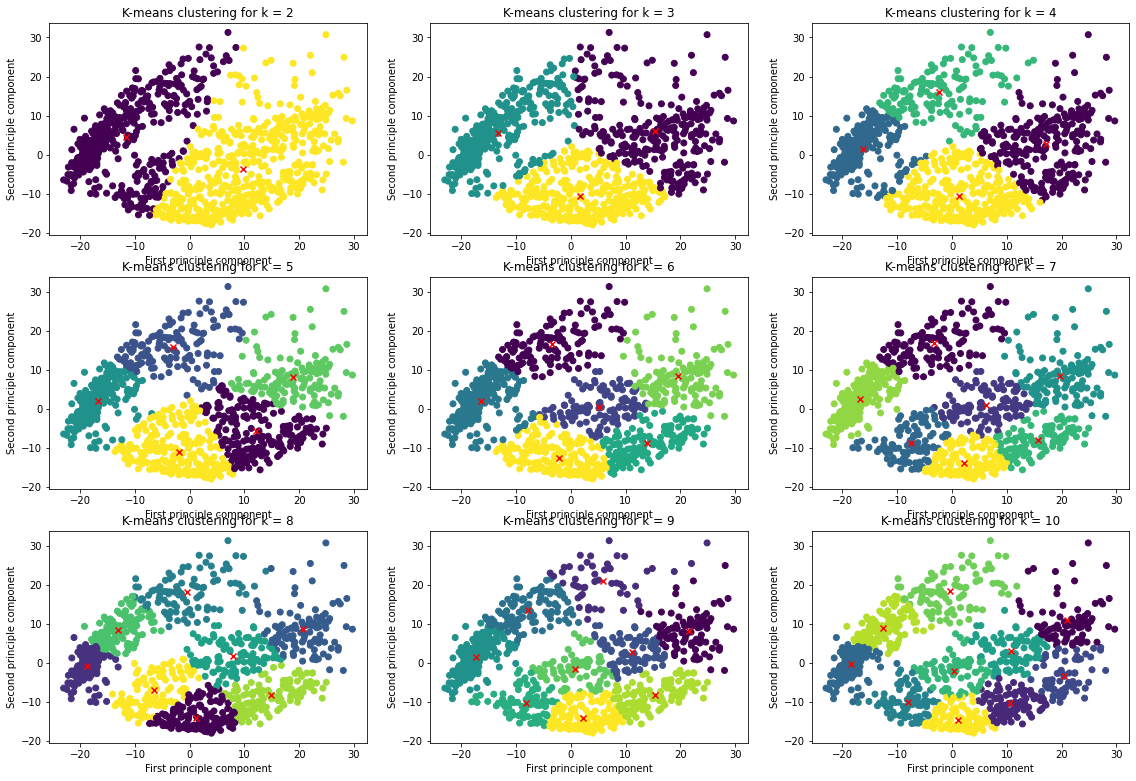

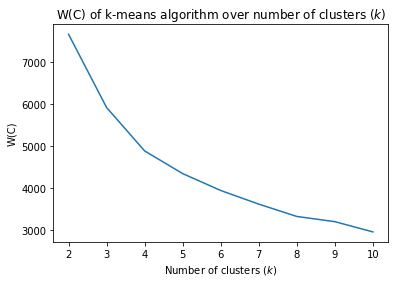

In [68]:
np.random.seed(MASTER_SEED)

#Choose only the first two components
q213_x = q211_x_pca[:, :2]
#Precompute pairwise distances matrix
q213_dists = pairwise_distances(q213_x)

k_scan = np.arange(2, 11)
Ws = []

fig, axs = plt.subplots(3, 3)
fig.subplots_adjust(
    left=0, right=2.5,
    bottom=0, top=2.5)

sample_count = q213_x.shape[0]
for k, ax in zip(k_scan, axs.flatten()):
    q213_cents, q213_classes = k_mean(q213_x, k)

    H = np.zeros((sample_count, k))
    #Create assignment matrix
    H[np.arange(sample_count), q213_classes] = 1

    W = np.trace(np.linalg.inv(H.T @ H) @ H.T @ q213_dists @ H) / 2
    Ws.append(W)

    ax.set_title(f"K-means clustering for k = {k}")
    ax.set_xlabel("First principle component")
    ax.set_ylabel("Second principle component")
    ax.scatter(q211_x_pca[:, 0], q211_x_pca[:, 1], c=q213_classes)
    ax.scatter(q213_cents[:, 0], q213_cents[:, 1], color="Red", marker="x")

plt.figure()
plt.title("W(C) of k-means algorithm over number of clusters ($k$)")
plt.xlabel("Number of clusters $(k)$")
plt.ylabel("W(C)")
plt.plot(k_scan, Ws)
plt.show()


The above graph of $W(C)$ displays an elbow somewhere between $k=3$ and $k=4$. The optimal cluster is chosen such that $W(C)$ is small and so are the number of clusters, hence the idea of looking for the elbow. It appears as those the optimal number of clusters is far from the total number of categories, looking at the plots above of the different clusters (Each with its own unique colouring) and the centroids (marked by red crosses) it is quite clear that the $k=10$ plot does not mimick the original plot in 2.1.3. Although the plot in 2.1.3 does have ten different categories, most of them seem to share the same region on the 2D plot. On this plot, if one were to focus on the dark green and the light green categories, it is quite evident to see that the majour bulk of them overlap at the tip of the smaller wing. The same is true for the purple and the dark blue points. Visually, to a person, the data above is better seperate into three or four clusters, bisecting the smaller wing so that the yellows have their own cluster then perhaps bisecting the larger wing so that the purples are wholy within one cluster. This clustering is very similar to what the k-means algorithm has done for $k=4$, hence with the addition previous choice of either $k=3$ or $k=4$, $k=4$ seems to cluster the data in a way that is more intuitive, when considering the categories assigned to each $\mathbf{x}^{(i)}$.

Optimal $k=4$

<a name="q22"></a>

## 2.2 Clustering of the feature matrix [^](#outline)

In [102]:
import pandas as pd

In [103]:
dolph_names_df = pd.read_csv("../res/dolphin_names.csv")
dolph_names = dolph_names_df.iloc[:, -1].to_numpy()

A_mat = np.load("../res/dolphins_A_62x62.npy")
F_mat = np.load("../res/dolphins_F_62x32.npy")

The next technique used, will be hierarchical clustering with group average as its merging criterion. Hierarchical clustering, as opposed to k-means, iteratively decreases the numbers of clusters, first assuming that each sample $\mathbf{x}^{(i)}$ is initially in its own cluster, by merging clusters at each level which minimise the given criterion. The group average criterion computes the following quanitity:

$$
d_{GA}(G, H) = \frac{1}{|G||H|}\sum_{i\in G, j \in H} D_{ij}
$$

Which measures the average distance over all pairs of elements $(g, h) \in G \times H$ (Here $\times$ represents the cartesian product). The choice of which two clusters to merge, would then be the two clusters that minimise the above metric.

In [104]:
def average_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the average linkage value between two clusters.
    Args:
      distances: A numpy array of pair-wise distances for the given points.
      cluster_assignment: A 1-D numpy array that assigns a cluster id for every point.
      i: the first cluster id.
      j: the second cluster id.
    Returns:
      The average distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i)
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j)
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the average
    return pairs_distance.mean()


In [105]:
def hierarchical_clustering(points, distances, linkage):
    """
    The hierarchical clustering algorithm start with every point as a single cluster and 
    each iteration merges two clusters into one. We may wish to store all the 
    intermediate clustering results with respect to the number of clusters left.

    Args:
     points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
     distances: A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
     linkage: A linkage function from the above to call to compute the linkage values between two clusters.

    Returns:
     A numpy array of shape (N, N) of which each row stores the clustering assignment at each level.
     The first row, i.e. a[0, :], represents the highest level of clustering where all columns have the same index value.
     The second row, i.e. a[1, :], represents all the points assigned into two cluster indices.
     The last row, i.e. a[N - 1, :], represents the points assigned into N - 1 cluster indices.
    """ 
    N, D = points.shape
    assignments = np.zeros((N, N))
    
    # Begin with every point is its own cluster
    current_assignment = np.arange(N)
    
    # The id to be assigned for the next merged cluster
    next_cluster_id = N
    
    # Begin from level (N - 1) to level 1
    for level in range(N - 1, 0, -1):
        if (level % 10) == 0:
            print(f'level:{level}')
        cluster_ids = np.unique(current_assignment)
        
        min_d = np.inf
        
        # Initialize the cluster ids to be merged in this iteration.
        cluster_a, cluster_b = (-1, -1) 
        
        # Now find the two clusters that have the minimum distance in between.
        for i in range(cluster_ids.size):
            for j in range(i + 1, cluster_ids.size):
                cluster_i = cluster_ids[i]
                cluster_j = cluster_ids[j]
                d = linkage(distances, current_assignment, cluster_i, cluster_j)
                if d < min_d:
                    min_d = d
                    cluster_a, cluster_b = (cluster_i, cluster_j)
                    
        
        # Merge the two clusters
        current_assignment[(current_assignment == cluster_a) | (current_assignment == cluster_b)] = next_cluster_id
        next_cluster_id += 1
        # Store the current cluster assignment into the assignments array.
        assignments[level, :] = current_assignment
        
    return assignments

In [173]:
distances = pairwise_distances(F_mat)
a = hierarchical_clustering(F_mat, distances, average_linkage).astype(int)
print("Clustering finished!")

#Priting levels from finest to coursest, excluding intialisation level and coursest level
print("Cluster labels from finest to coursest:")
print(a[2:][::-1])

level:60
level:50
level:40
level:30
level:20
level:10
Clustering finished!
Cluster labels from finest to coursest:
[[  0   1   2 ...  59  60  61]
 [  0   1   2 ...  59  60  61]
 [  0   1   2 ...  59  60  61]
 ...
 [113 117 113 ... 118 117 119]
 [120 117 120 ... 118 117 120]
 [121 117 121 ... 121 117 121]]


The sihlouette score will be used as metric for deciding the optimal number of clusters for the above hierarchical algorithm. The score is calculate as the mean sihlouette coefficient over all sample points $\mathbf{x}^{(i)}$, as given by:

$$
\text{Sihlouette Coefficient}_i = \frac{d2(i) - d1(i)}{\max(d2(i),d1(i))}
$$

Where $d1$ is the mean distance between the sample and all other points in its cluster:

$$
d1(i) = \frac{1}{|c_l| - 1} \sum_{\mathbf{x}^{(i)}\not=\mathbf{x}^{(j)} \in c_l} ||\mathbf{x}^{(i)} - \mathbf{x}^{(j)}||^2, \hspace{1em} \text{for $c_l$ such that } \mathbf{x}^{(i)}\in c_l
$$

And d2 the mean distance over all the points in the nearest cluster that it isn't part of. Where the nearest cluster minimises the average distance from the sample point to all elements in said cluster:

$$
d2(i) = \min_{J\not=I} \frac{1}{|c_J|} \sum_{\mathbf{x}^{(j)} \in c_J}||\mathbf{x}^{(i)} - \mathbf{x}^{(j)}||^2
$$

Finally, the Sihlouette Score may be computed as:

$$
\text{Sihlouette Score} = \frac{1}{|\mathbf{X}|}\sum_{\mathbf{x}^{(i)} \in \mathbf{X}} \frac{d2(i) - d1(i)}{\max(d2(i),d1(i))}
$$

The sihlouette coefficient is a value between $-1$ and $1$, representing how well the sample point fits in its own cluster, with 1 representing a perfect fit and -1 a complete mismatch. It does this by measuring how well this sample point would fit into another cluster (the nearest one) and compares it with the fit in its current cluster. However, there are some edge cases to consider using this metric. Namely, d1 is undefined for singletons, indeed the denominator of the mean for the singleton evalues to zero. A value needs to be assigned for this special case, typically this is just 0. Setting $1$ as the sihlouette coefficient for sigletons, would trivially result in saying that a sample fits best in its own cluster, hence favouring a greater number of smaller clusters as opposed to few large one. This is contrary to our wishes, which is to group the data as coursely as possible, hence 1 is a poor choice for this edge case. On the other hand, setting this value to $-1$ would suggest that all singletons are incorrectly placed, yet this also causes problems when considering nodes that are genuinely disconnected from the network, which would give poor scores for such nodes. Relating this back to the dolphins, consider perhaps a dolphin that is very different from the rest of the herd, perhaps significantly larger (perhaps an alpha) or disabled in some way, it would make sense for this dolphin to be an outlier thus reasonable for he/she to be clustered seperately. Therefore, 0 is a neutral score, not biased towards any outcome and thus most fitting for this case.

The other potentially problematic case, is when considering the coursest level, with only one cluster. This case leaves $d2$ undefined, however this course set is of little interest to us as it is the same as not clustering the data at all. Hence, undefined behaviour here will never occur as this set will not be considered.

In [107]:
def silhouette_coeff(cluster_assignment, sample_index, distances):
    """Computes the silhouette coefficient for the given sample point

    Args:
        cluster_assignment (np.array): A 1-D numpy array that assigns a cluster id for every point.
        sample_index            (int): The sample on which to calculate the coefficient.
        distances          (np.array): A square numpy matrix of parwise distances between points in X 

    Returns:
        float: A float between (-1, 1) represeting the silhouette coefficient
    """

    #Get the cluster of the sample point
    sample_cluster_index = cluster_assignment[sample_index]

    cluster_indicies = np.unique(cluster_assignment)
    mean_cluster_dists = []

    d1 = 0
    for cluster_index in cluster_indicies:
        #Get all the distances from the sample point to the cluster
        cluster_point_dists = distances[sample_index, cluster_assignment==cluster_index]
        #Take the mean of the distances
        mean_dist = cluster_point_dists.mean()

        #If the cluster_index matches the samples cluster then calculate d1
        if(cluster_index == sample_cluster_index):
            cluster_size = len(cluster_point_dists)

            if (cluster_size > 1):
                # mean_dist includes D(sample_point, sample_point)=0 in its
                # mean, hence to remove this point simply multiply by the scalar
                # below to decrease denominator by 1.
                d1 = mean_dist * cluster_size / (cluster_size - 1.0)
            else:
                #Doesn't make sense for a singleton to have a score dictating
                #whether it belongs or doesn't to another cluster. Hence,
                #choose neutral outcome 
                return 0
        #Otherwise append to list in hopes this is the nearest cluster
        else:
            mean_cluster_dists.append(mean_dist)

    d2 = np.min(mean_cluster_dists)

    return (d2 - d1)/max(d1, d2)


def silhouette_score(cluster_assignment, distances):
    """
    Args:
        cluster_assignment (np.array): A 1-D numpy array that assigns a cluster id for every point.
        distances          (np.array): A square numpy matrix of parwise distances between points in X 

    Returns:
        float: A float between (-1, 1) representing the silhouette score of the clusterings
    """

    sample_count = len(cluster_assignment)

    acc = 0
    for sample_index in range(sample_count):
        acc += silhouette_coeff(cluster_assignment, sample_index, distances)
    
    return acc / sample_count


Optimal clustering level: 1


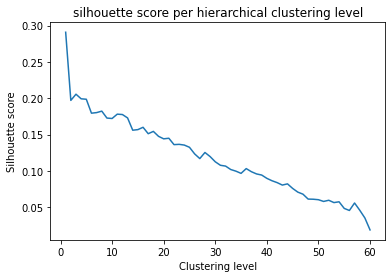

In [108]:
#Remove the first two levels (The initialisation level of all 0s and the coursest level with only 1)
h_clusters = (a[2:])

silhouette_scores = []
for clustering in h_clusters:
    silhouette_scores.append(silhouette_score(clustering, distances))

print("Optimal clustering level:", np.argmax(silhouette_scores) + 1)

plt.figure()
plt.title("silhouette score per hierarchical clustering level")
plt.xlabel("Clustering level")
plt.ylabel("Silhouette score")
plt.plot(np.arange(len(h_clusters)) + 1, silhouette_scores)
plt.show()

The silhoutte algorithm has deduced that two clusters perform significantly better than any more.

<a name="q23"></a>

## 2.3 Graph-based analysis  [^](#outline)

In [149]:
import networkx as nx

Next, a spectral partion of the graph will be performed. The key idea behind this algorith is to minimise the 'cut' or the number edges between the two partions $S_1$ and $S_2$. In other words, the cost may be written as:

$$
C = \frac{1}{2} \sum_{i\in S_1, j \in S_2} A_{ij}
$$

Where $A$ is the adjacency matrix, where clearly $A_{ij} = 0$ for if nodes $i$ and $j$ are not connect and $1$ otherwise. Due the symmetric nature of this matrix, each edge will be counted twice, hence this is discounted by halving the result. One may rewrite the above in terms of the two, related, indicator functions:

$$
s_{i} = \begin{cases}1 & \text{ if } i \in S_1 \\ -1 & \text{ if } i \in S_2 \end{cases},\hspace{1em} t_{ij} = \frac{1}{2}(1 - s_i s_j) = \begin{cases}1 & \text{ if } i, j \text{ are in the different clusters} \\ 0 & \text{ if } i, j \text{ are in the same cluster}\end{cases}
$$

$$
\begin{split}
C = \frac{1}{2} \sum_{i, j} t_{ij}A_{ij} &= \frac{1}{4}\left( \sum_{i, j} A_{ij} - \sum_{i, j}A_{ij}s_{i}s_{j} \right)\\ &= \frac{1}{4}\left( \sum_{i} d_i - \sum_{i, j}A_{ij}s_{i}s_{j} \right)\\ &= \frac{1}{4}\left( \sum_{i} d_i s_i^2 - \sum_{i, j}A_{ij}s_{i}s_{j} \right)\\ &= \frac{1}{4}\left( \sum_{ij} d_i s_is_j\delta_{ij} - \sum_{i, j}A_{ij}s_{i}s_{j} \right) \\&= \frac{1}{4}\left( \sum_{ij} s_i(d_i \delta_{ij} - A_{ij}) s_j\right)
\end{split}
$$

Noticing that $d_i \delta_{ij} - A_{ij} = L_{ij}$ where the $L$ is the combinatorial laplacian, the above simplifies to the problem of finding $\mathbf{s} \in \{-1, 1\}^N$ such that:

$$
C = \frac{1}{4}\mathbf{s}^T L \mathbf{s} \hspace{1em}\text{ is minimal for } \mathbf{s} \text { such that } \begin{cases}||\mathbf{s}||^2 = n_1 + n_2 = N \\ \mathbf{s}^T \cdot \mathbf{1} = n_1 - n_2 \end{cases}
$$

Where $n_1$ and $n_2$ are the sizes of the partitions $S_1$ and $S_2$, respectively. Unfortunately, the above is a combinatorial problem and thus very difficult to solve. To solve this issue, we relax the problem allow for $\mathbf{s} \in \mathbb{R}^N$. And solve this problem by means of lagrange multipliers:

$$
\mathcal{L}(\mathbf{s}, \lambda, \mu) = \frac{1}{4}\mathbf{s}^T L \mathbf{s} + \lambda(N - ||\mathbf{s}||^2) + \mu(n_1 - n_2 -\mathbf{s}^T \cdot \mathbf{1})
$$

Which can be differentiated with respect to $\mathbf{s}$:

$$
\nabla_{\mathbf{s}}\mathcal{L}(\mathbf{s}, \lambda, \mu) = \frac{1}{2} L\mathbf{s} - 2 \lambda \mathbf{s} - \mu \mathbf{1}
$$

Which leads to the problem of calculating:
$$
\frac{1}{2} L\mathbf{s} = 2 \lambda \mathbf{s} + \mu \mathbf{1} \iff L\mathbf{s} = \lambda \mathbf{s} + \mu \mathbf{1}
$$

Multiplying by $\mathbf{1}^T$ and using the restrictions set out before-hand plus the fact that by definition of the laplacian $\mathbf{1}^T L = 0$:

$$
\mathbf{1}^TL\mathbf{s} = \lambda \mathbf{1}^T\mathbf{s} + \mu \mathbf{1}^T\mathbf{1} \implies 0 = \lambda(n_1 - n_2) + \mu N \implies \frac{\mu}{\lambda}=\frac{n_2 - n_1}{N}
$$

Finally, reusing that $L \mathbf{1} = 0$, the problem may be written as:

$$
L\left(\mathbf{s}^* + \frac{\mu}{\lambda}\mathbf{1}\right) = \lambda\left(\mathbf{s}^* + \frac{\mu}{\lambda}\mathbf{1}\right)
$$

A simple eigenvector problem involving the laplacian. The question remains, which eigen-value is desired? Define $\mathbf{v} =\mathbf{s}^* + \frac{\mu}{\lambda}\mathbf{1}$, an eigenvector of $L$. Substituting this back into the cost function:

$$
C(\mathbf{v}) = \frac{1}{4} \mathbf{v^T} L \mathbf{v} = \frac{1}{4}\lambda\mathbf{v^T}\mathbf{v}
$$

A quick calculation shows that $\mathbf{v}^T \mathbf{v} = 4\frac{n_1 n_2}{N}$, hence the cost is given by:

$$
C = \lambda\frac{n_1 n_2}{N}
$$

Where clearly, the minimum eigen-vector is the one desired. However, The laplacian has a nullspace, with $\mathbf{1}$ as its eigen vector and $\lambda=0$ as its eigenvalue. This cannot be the solution given the condition that: $\mathbf{1}^T \mathbf{v} = \mathbf{1}^T \mathbf{s^*} + \frac{\mu}{\lambda}\mathbf{1}^T \mathbf{1} = (n_1 - n_2) + \frac{n_2 - n_1}{N}N = 0$. Where $\frac{\mu}{\lambda}$ was calculated to be $\frac{n_2 - n_1}{N}$ for minimial solutions. Hence, the eigenvector with the second largest eigenvalue will the one that minimises the cost. The final problem involves finding $\mathbf{s}$ close to optimal $\mathbf{s}^*$ for the relaxed problem. This will be simply done by take the optimal relaxed solution eigenvector $\mathbf{v}$ and transforming it such that $\mathbf{s}_i = \begin{cases}1 & \mathbf{v}_i > 0 \\ -1 & \mathbf{v}_i \leq 0\end{cases}$. However, since the clusters are labeled $\{0, 1\}$, $\mathbf{s}$ will be tweaked in the following way: 

$$
\mathbf{s}_i = \begin{cases}1 & \mathbf{v}_i > 0 \\ 0 & \mathbf{v}_i \leq 0\end{cases}
$$


In [150]:
np.random.seed(MASTER_SEED)

deg_A = np.sum(A_mat, axis=1)
lap_A = deg_A - A_mat

deg_A_sqrt = 1.0 / np.sqrt(deg_A)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(deg_A_sqrt)

# define the normalised Laplacian (Has same eigen_vectors as combinatorial laplacian)
lap_A_norm = np.eye(A_mat.shape[0]) - D_inv_sqrt @ A_mat @ D_inv_sqrt

LAN_eigenvalues, LAN_eigenvectors = linalg.eigsh(lap_A_norm, 2, which="SM", return_eigenvectors=True)

print("Eigen-values:", LAN_eigenvalues) 


Eigen-values: [4.31241414e-17 3.95245538e-02]


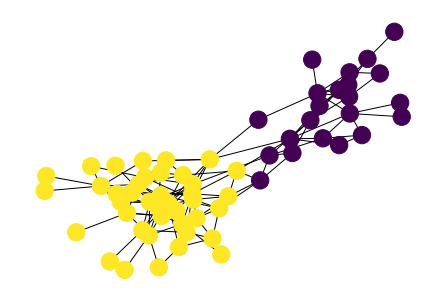

In [151]:
np.random.seed(MASTER_SEED)

# define a partition and binarize the negative and positive eigenvector values
spectral_partition = LAN_eigenvectors[:,1]
spectral_partition[spectral_partition<0] = 0
spectral_partition[spectral_partition>0] = 1

# draw the spectral partition
g = nx.Graph(A_mat)
nx.draw(g, node_color=spectral_partition)

It is quite evident to see that the bipartion was successful. Indeed, the first smallest eigen-value zero, as expected (With some numerical precision errors), while the second smallest eigenvalue is very small, hence a good bipartition. This is clearly visible in that there are very few, a count count shows that there are approximately seven or so edges between the two clusters.

Next, applying degree centrality, eigenvector centrality and PageRank centrality to the network:

Dolphins ranked by centrality (Decreasing)
['Grin' 'Topless' 'SN4' 'Scabs' 'Trigger' 'Jet' 'Web' 'Patchback'
 'Kringel' 'Gallatin' 'SN63' 'SN9' 'Beescratch' 'Jonah' 'Feather' 'SN100'
 'Haecksel' 'Upbang' 'Stripes' 'TR99' 'MN105' 'MN83' 'Beak' 'SN96' 'Hook'
 'TR77' 'Double' 'DN21' 'Fish' 'DN63' 'Number1' 'Oscar' 'PL' 'SN90' 'Zap'
 'Shmuddel' 'Knit' 'TSN103' 'DN16' 'Thumper' 'Bumper' 'CCL' 'Zipfel'
 'MN60' 'Ripplefluke' 'Mus' 'Notch' 'SN89' 'TR120' 'TR88' 'TSN83' 'Vau'
 'Wave' 'Whitetip' 'Cross' 'Zig' 'Five' 'Fork' 'Quasi' 'SMN5' 'MN23'
 'TR82']

Centralities (Decreasing):
[0.19672131 0.18032787 0.18032787 0.16393443 0.16393443 0.14754098
 0.14754098 0.14754098 0.14754098 0.13114754 0.13114754 0.13114754
 0.13114754 0.1147541  0.1147541  0.1147541  0.1147541  0.1147541
 0.1147541  0.1147541  0.09836066 0.09836066 0.09836066 0.09836066
 0.09836066 0.09836066 0.09836066 0.09836066 0.08196721 0.08196721
 0.08196721 0.08196721 0.08196721 0.08196721 0.08196721 0.08196721
 0.06557377 0.0655737

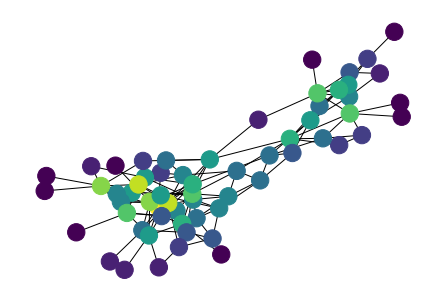

In [163]:
np.random.seed(MASTER_SEED)

deg_centrality = deg_A / (len(deg_A) - 1)
nx.draw(g, node_color=deg_centrality)
deg_sorted_indicies = np.argsort(deg_centrality)[::-1]

#Dolphins printed in descending order of highest centrality
print("Dolphins ranked by centrality (Decreasing)")
print(dolph_names[deg_sorted_indicies])
print("\nCentralities (Decreasing):")
print(deg_centrality[deg_sorted_indicies])

Dolphins ranked by centrality (Decreasing)
['Grin' 'SN4' 'Topless' 'Scabs' 'TR99' 'Patchback' 'Trigger' 'Hook' 'SN9'
 'MN105' 'Jonah' 'SN63' 'MN83' 'Stripes' 'Kringel' 'Haecksel' 'Double'
 'Shmuddel' 'SN100' 'TSN103' 'Beak' 'Zap' 'MN60' 'SN96' 'TR77' 'CCL'
 'Thumper' 'Fish' 'Oscar' 'Vau' 'Zipfel' 'DN63' 'Beescratch' 'PL' 'Bumper'
 'Fork' 'TSN83' 'TR120' 'SMN5' 'Cross' 'Five' 'Whitetip' 'TR88' 'Upbang'
 'SN89' 'Knit' 'Jet' 'Web' 'Number1' 'SN90' 'Gallatin' 'Feather' 'DN21'
 'Notch' 'DN16' 'Mus' 'Ripplefluke' 'Wave' 'Quasi' 'MN23' 'TR82' 'Zig']

Centralities (Decreasing):
[0.31578285 0.30056205 0.28500522 0.28109869 0.21769179 0.21176308
 0.21068221 0.20799426 0.20787191 0.2073514  0.20249469 0.19661764
 0.19321357 0.19033934 0.18447739 0.16417581 0.14310214 0.13882809
 0.1327621  0.12956429 0.12850353 0.11181862 0.08736214 0.0809501
 0.08037062 0.07933476 0.07780237 0.07525347 0.0682235  0.05210983
 0.0519914  0.04290099 0.04207615 0.04074725 0.03975712 0.03907614
 0.03368693 0.02971651

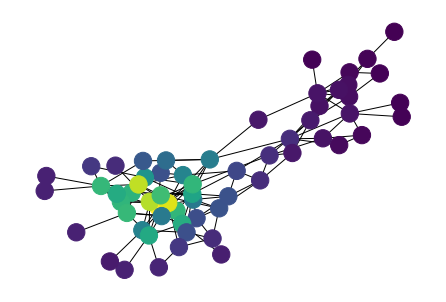

In [164]:
np.random.seed(MASTER_SEED)

eigenval_centrality, eigenvec_centrality = linalg.eigsh(A_mat, 1, which="LM", return_eigenvectors=True)
#Sometimes the negative part of the eigenvector
#is returned by eigsh, correct this so that it
#is always postive
if(eigenvec_centrality[0] < 0):
    eigenvec_centrality = -eigenvec_centrality

nx.draw(g, node_color=eigenvec_centrality)

spec_sorted_indicies = np.argsort(eigenvec_centrality.flatten())[::-1]

#Dolphins printed in descending order of highest centrality
print("Dolphins ranked by centrality (Decreasing)")
print(dolph_names[spec_sorted_indicies])
print("\nCentralities (Decreasing):")
print(eigenvec_centrality.flatten()[spec_sorted_indicies])

Next, the PageRank centrality is used, which equates to solving for the stationary eigen-vector of the equation below:

$$
\mathbf{cpr}_{t+1} = \alpha(AD^{-1})\mathbf{cpr}_{t} + (1-\alpha)\frac{1}{N}\mathbf{1}
$$

Since, the dolphin graph is small, this may be solved exactly by considering the limit as $t\to\infty$, hence reducing the problem to solving:

$$
\mathbf{cpr} = \alpha(AD^{-1})\mathbf{cpr} + (1-\alpha)\frac{1}{N}\mathbf{1}
$$

Hence, by rearranging:

$$
\mathbf{cpr} = (I - \alpha (AD^{-1}))^{-1} \frac{1}{N}\mathbf{1}
$$

A typical value for $\alpha$, which will also be used here, is $\alpha=0.85$.


Dolphins ranked by centrality (Decreasing)
['Grin' 'Jet' 'Trigger' 'Web' 'SN4' 'Topless' 'Scabs' 'Patchback'
 'Gallatin' 'Beescratch' 'Kringel' 'SN63' 'Feather' 'SN9' 'Stripes'
 'Upbang' 'SN100' 'DN21' 'Haecksel' 'Jonah' 'TR99' 'SN96' 'TR77' 'Number1'
 'Double' 'Beak' 'MN105' 'MN83' 'Hook' 'SN90' 'Shmuddel' 'DN63' 'PL'
 'Fish' 'Oscar' 'Zap' 'DN16' 'Bumper' 'Ripplefluke' 'Knit' 'Thumper'
 'TSN103' 'Mus' 'Notch' 'Zipfel' 'MN60' 'CCL' 'TR88' 'TR120' 'Wave'
 'TSN83' 'SN89' 'Vau' 'Zig' 'MN23' 'Quasi' 'TR82' 'Five' 'Cross'
 'Whitetip' 'SMN5' 'Fork']

Centralities (Decreasing):
[0.22803052 0.22507695 0.2220352  0.21349422 0.21193332 0.20937146
 0.20163104 0.18769489 0.18555484 0.17487026 0.17480076 0.16982313
 0.16641262 0.15582769 0.15387515 0.15358963 0.14622978 0.14225888
 0.14104903 0.13759052 0.13642992 0.12498533 0.12300519 0.12151953
 0.12129401 0.12035117 0.12016387 0.11992811 0.11794934 0.11447864
 0.11293478 0.11097044 0.10855187 0.10717779 0.10531451 0.10476247
 0.10235144 0.094619

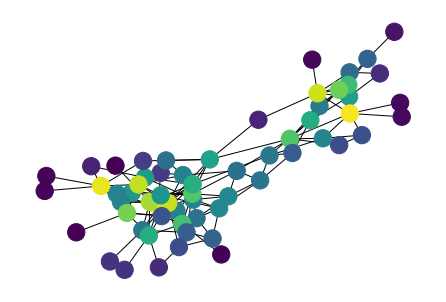

In [165]:
np.random.seed(MASTER_SEED)

N = A_mat.shape[0]
I = np.identity(N)
D = np.diag(deg_A)

alpha = 0.85
cpr = np.linalg.solve(I - alpha * (A_mat @ np.linalg.inv(D)), np.ones(N))/N
#normalise centralities
cpr = cpr/np.linalg.norm(cpr)

nx.draw(g, node_color=cpr)

cpr_sorted_indicies = np.argsort(cpr)[::-1]

#Dolphins printed in descending order of highest centrality
print("Dolphins ranked by centrality (Decreasing)")
print(dolph_names[cpr_sorted_indicies])
print("\nCentralities (Decreasing):")
print(cpr[cpr_sorted_indicies])

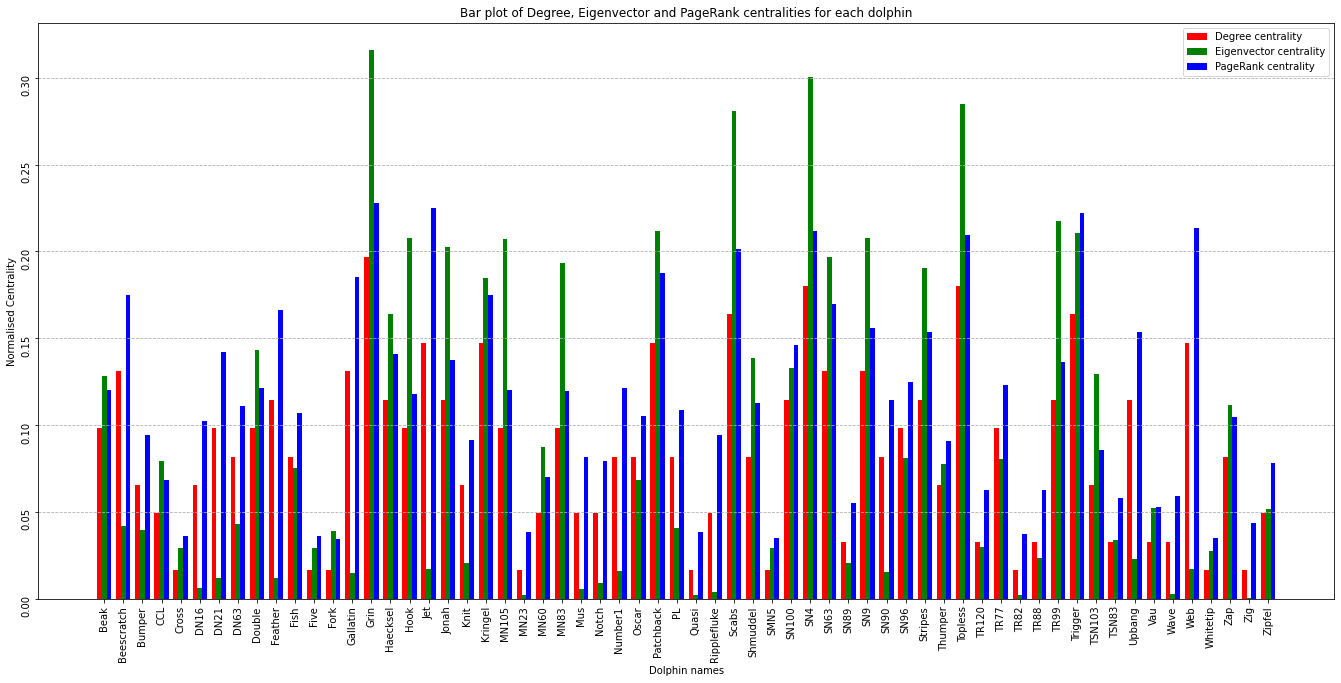

In [174]:
plt.figure()
plt.title("Bar plot of Degree, Eigenvector and PageRank centralities for each dolphin")
plt.xlabel("Dolphin names")
plt.ylabel("Normalised Centrality")
plt.subplots_adjust(
    left=0, right=3,
    bottom=0, top=2)

x = np.arange(len(dolph_names))
plt.xticks(x, dolph_names)
plt.tick_params(rotation=90)

plt.bar(x - 0.25, deg_centrality,                width=0.25, color="Red"  , label="Degree centrality")
plt.bar(x      , eigenvec_centrality.flatten(), width=0.25, color="Green", label="Eigenvector centrality")
plt.bar(x + 0.25, cpr,                           width=0.25, color="Blue" , label="PageRank centrality")

plt.grid(axis="y", linestyle="--")
plt.legend()
plt.show()

The different centralities provide different yet interesting results. Honing in on one of the most discused dolphin, Trigger, it is quite clear to see that she ranks high in almost all of the centrality tests. Indeed, according to the article, Trigger is found to hold a central position in groups 2 and 3 but only has significant relationships with members of the group containing Jonah and topless. This is instructive as to why she ranks highly in both degree centrality and PageRank centrality, whereby being central to not only one but two groups would suggest she posses a wide spread network which is favoured by degree centrality. Morever, focusing on Figure 5 from the article, it is clear that she has connections with Topless who ranks top 2, top 3 and top 6 in each respective centrality metric. This is to imply that Trigger has connections to nodes which have high centralities resulting in high rankings in both the eigenvector and PageRank tests.

Another very well connected dolphin is 'Topless', mentioned briefly before, dolphin holds a central position in his group, as is mentioned by the article, and this is reflected in his centrality scores which places him near the top for most centralities. This is perhaps well explained seeing that Web and Topless have 33% percent of significant male-female relationships in the group. It is therefore no surprise that they score greatly when it comes to their degree scores. The difference between these two, is made abundantly clear in their Eigenvector score. Whilst Topless has close connections to many widespread dolphins such as 'Trigger' and 'Jonah', Web has a similar degree but its group contains less highly central individuals but overall more leveled out, resulting in great PageRank scores but low Eigenvector scores.